In [45]:
import os
import glob

from tqdm import tqdm

import math
import netCDF4 as nc
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import platform
import importlib
import h5py
from pathlib import Path
from types import ModuleType  # Import ModuleType to check for modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr

import re
from datetime import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')

import HydroAI.Plot as hPlot
import HydroAI.Grid as hGrid
import HydroAI.Data as hData
import HydroAI.LULC as hLULC
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

In [2]:
base_dir = cpuserver_data_FP+"/CYGNSS/L1_V21"
nc_file_list = hData.get_file_list(base_dir, 'nc4')

In [3]:
#ref_lon, ref_lat = hSMAP.get_e2grid(cpuserver_data_FP, 'SPL3SMP.006')
ref_lon, ref_lat = hGrid.generate_lon_lat_e2grid('36km')
#ref_lon, ref_lat = hGrid.generate_lon_lat_eqdgrid(0.05)

data_count = np.zeros_like(ref_lat, dtype=int)
# Flatten the reference arrays and stack them as [latitude, longitude]
ref_points = np.column_stack((ref_lat.flatten(), ref_lon.flatten()))
tree = cKDTree(ref_points)

Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


In [4]:
def cal_base_sec(time_units):
    match = re.search(r'seconds since (\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{6})', time_units)
    if match:
        original_base_date_str = match.group(1)
    
    original_base_datetime = datetime.strptime(original_base_date_str, '%Y-%m-%d %H:%M:%S.%f')
    
    delta_seconds = (original_base_datetime - new_base_datetime).total_seconds()
    return delta_seconds

def initialize_with_empty_lists(shape):
    data = np.empty(shape, dtype=object)
    for (r, c), _ in np.ndenumerate(data):
        data[r, c] = []
    return data

def clear_lists(arr):
    clear_func = np.frompyfunc(lambda x: x.clear(), 1, 1)
    clear_func(arr)

# Initialize arrays for accumulating sums and counts
angle_sum = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
angle_sum_sq = np.zeros_like(ref_lat, dtype=float)  # Sum values for each grid cell
data_count = np.zeros_like(ref_lat, dtype=int)  # Count of measurements for each grid cell

#timestamp_all_ddm = initialize_with_empty_lists(ref_lat.shape)
timestamp_all_update = initialize_with_empty_lists(ref_lat.shape)
timestamp_median = initialize_with_empty_lists(ref_lat.shape)

new_base_datetime = datetime(2017, 1, 1)
for i, file_name in tqdm(enumerate(nc_file_list[:1000]), total=len(nc_file_list[:1000]), desc="Processing Files"):
    dataset = nc.Dataset(file_name)
    sp_lat = dataset.variables['sp_lat'][:].flatten().compressed()
    sp_lon = dataset.variables['sp_lon'][:].flatten().compressed() - 180
    sp_inc_angle = dataset.variables['sp_inc_angle'][:].flatten().compressed()
    time_units = dataset.variables['ddm_timestamp_utc'].units #since xx
    timestamp = dataset.variables['ddm_timestamp_utc'][:].flatten().compressed() + cal_base_sec(time_units)
    timestamp = np.tile(timestamp, (4, ))
    sat_points = np.column_stack((sp_lat, sp_lon))
    _, indices = tree.query(sat_points)
    
    rows, cols = np.unravel_index(indices, ref_lat.shape)

    clear_lists(timestamp_all_update)
    for row, col, angle, time in zip(rows, cols, sp_inc_angle, timestamp):
        angle_sum[row, col] += angle
        angle_sum_sq[row, col] += angle ** 2
        data_count[row, col] += 1
        #timestamp_all_ddm[row, col].append(time)
        timestamp_all_update[row, col].append(time)
        
    for r in range(timestamp_all_update.shape[0]):
        for c in range(timestamp_all_update.shape[1]):
            if len(timestamp_all_update[r, c]) >= 1:  # Ensure there are enough timestamps to calculate a difference
                timestamp_median[r,c].append(np.median(timestamp_all_update[r, c]))


Processing Files:  52%|███████████████████████████████████▋                                 | 517/1000 [1:44:22<1:37:30, 12.11s/it]


KeyboardInterrupt: 

In [5]:
median_time_differences = np.empty(ref_lat.shape, dtype=float)

for r in range(timestamp_median.shape[0]):
    for c in range(timestamp_median.shape[1]):
        if len(timestamp_median[r, c]) > 1:  # Ensure there are enough timestamps to calculate a difference
            timestamp_median[r, c].sort()  # Sort timestamps in place
            
            # Calculate differences and the average
            differences = np.diff(timestamp_median[r, c])
            median_diff = np.median(differences)
            median_time_differences[r, c] = median_diff
        else:
            median_time_differences[r, c] = None  # No data to process

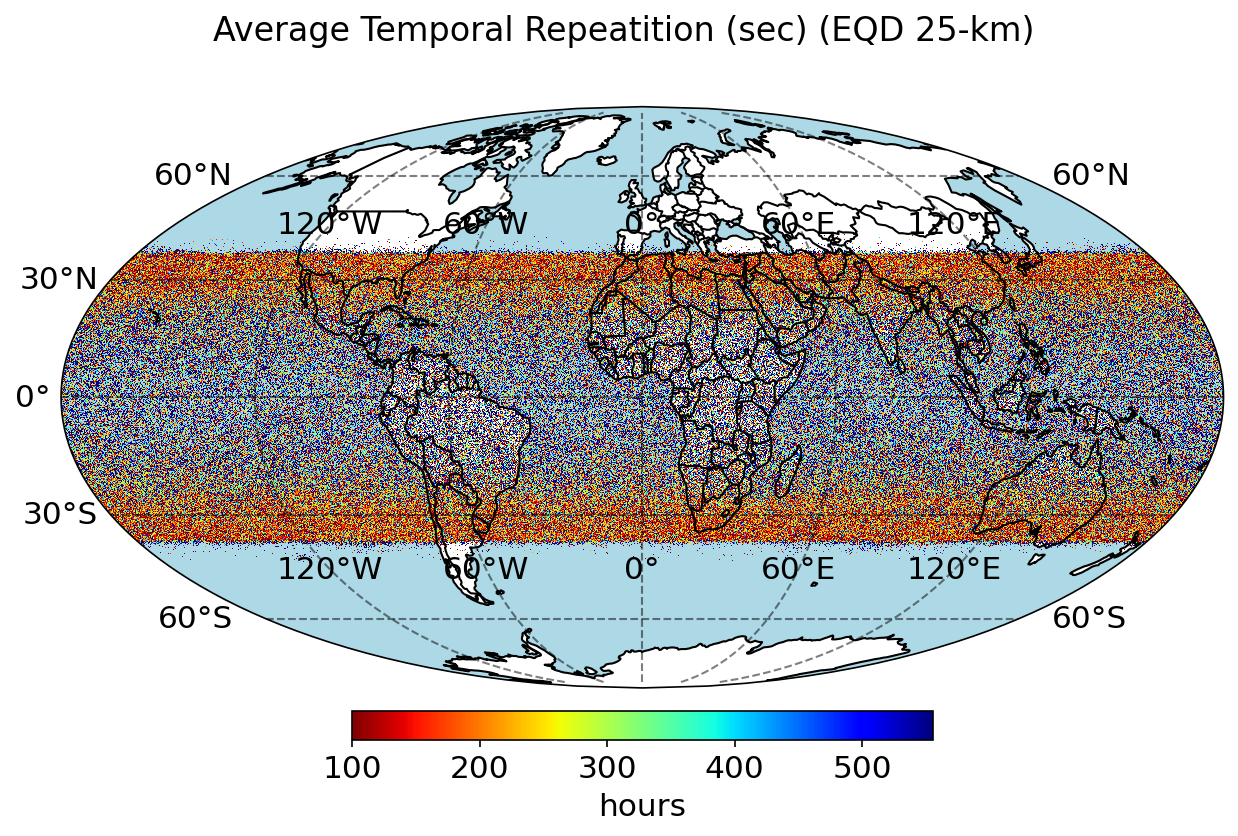

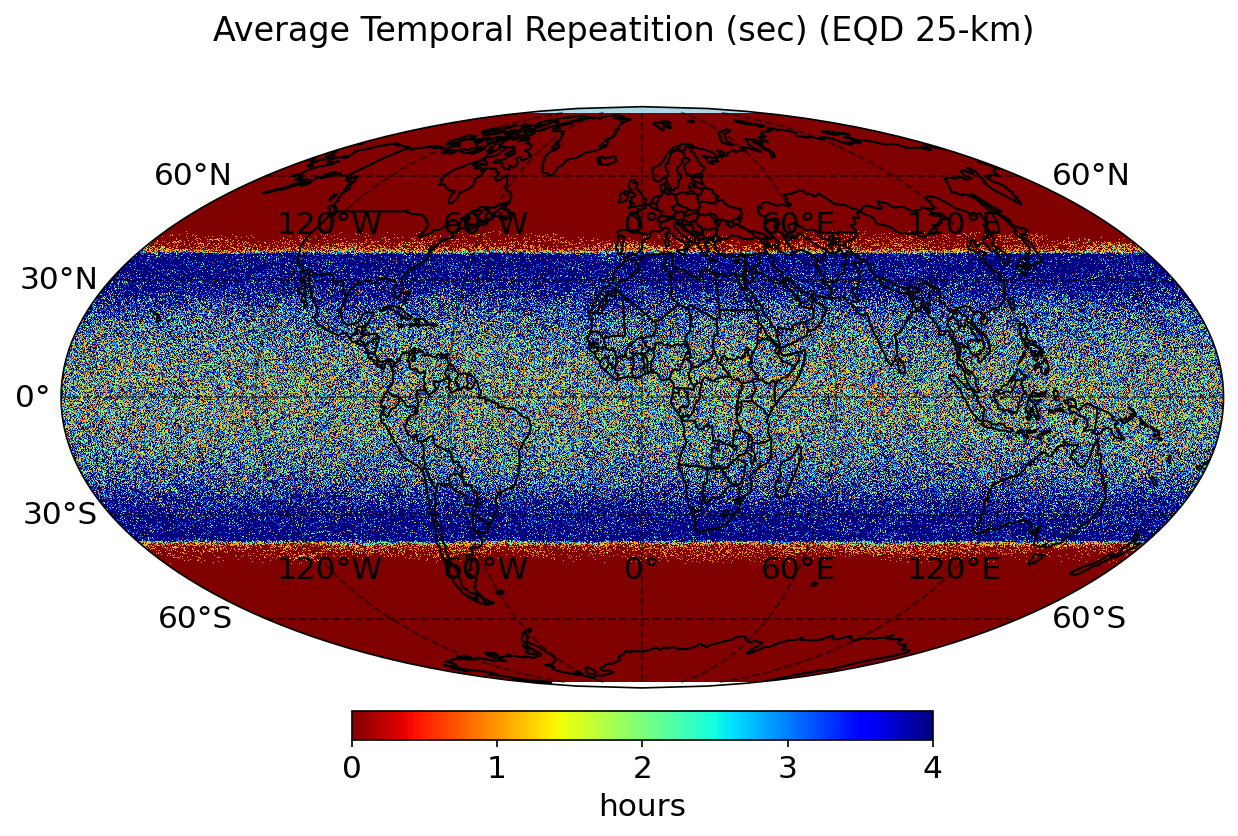

2.0


In [6]:
t = median_time_differences / 60 / 60
hPlot.plot_map(ref_lon, ref_lat, t, np.nanpercentile(t, 10), np.nanpercentile(t, 80), plot_title='Average Temporal Repeatition (sec) (EQD 25-km)', label_title='hours', cmap='jet_r', projection='Mollweide')
t = data_count
hPlot.plot_map(ref_lon, ref_lat, t, np.nanpercentile(t, 10), np.nanpercentile(t, 80), plot_title='Average Temporal Repeatition (sec) (EQD 25-km)', label_title='hours', cmap='jet_r', projection='Mollweide')
print(np.nanmedian(t))

In [525]:
average_time_differences = np.empty(ref_lat.shape, dtype=float)

for r in range(timestamp_all.shape[0]):
    for c in range(timestamp_all.shape[1]):
        if len(timestamp_all[r, c]) > 1:  # Ensure there are enough timestamps to calculate a difference
            timestamp_all[r, c].sort()  # Sort timestamps in place
            
            # Calculate differences and the average
            differences = np.diff(timestamp_all[r, c])
            #print(np.median(differences))
            
            average_diff = np.median(differences)
            average_time_differences[r, c] = average_diff
        else:
            average_time_differences[r, c] = None  # No data to process

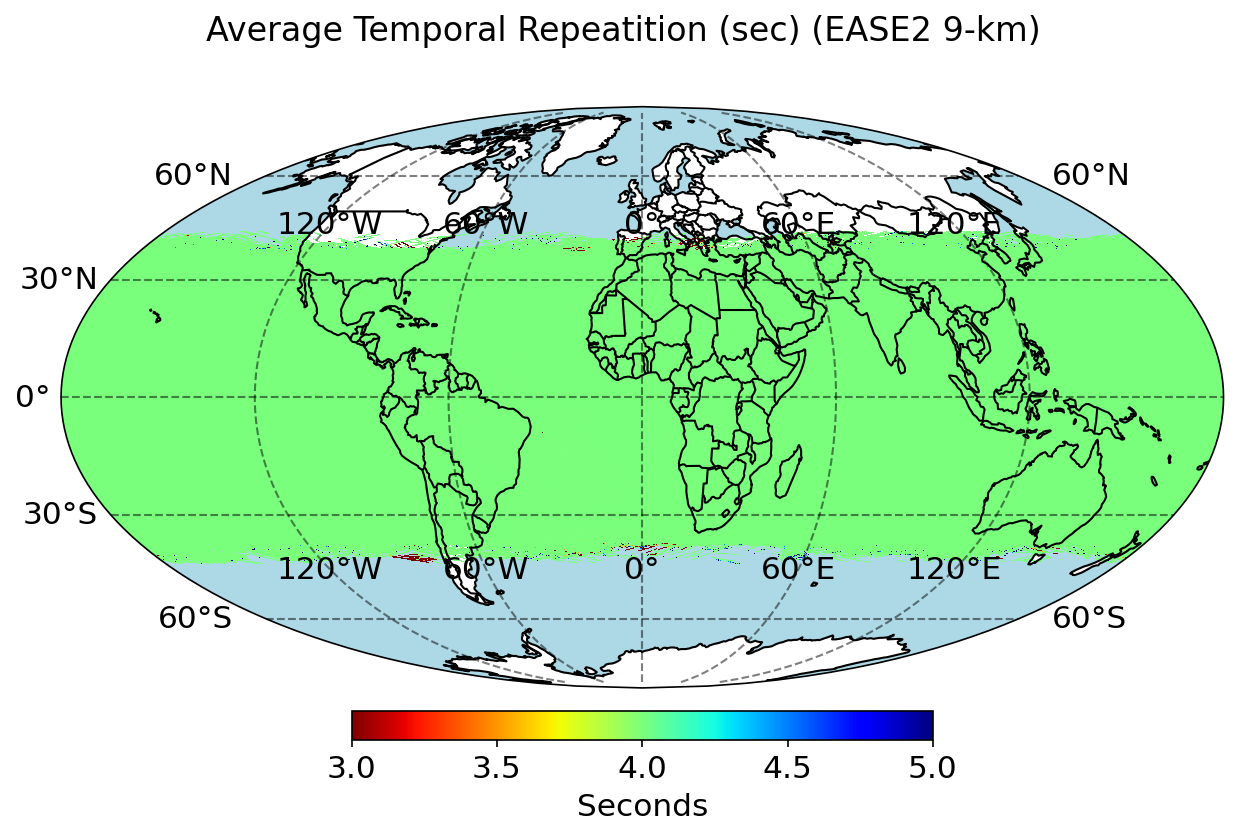

4.000000072643161


In [526]:
t = average_time_differences
hPlot.plot_map(ref_lon, ref_lat, t, math.ceil(np.nanpercentile(t,0)), math.ceil(np.nanpercentile(t, 20)), plot_title='Average Temporal Repeatition (sec) (EASE2 9-km)', label_title='Seconds', cmap='jet_r', projection='Mollweide')
#hPlot.plot_map(ref_lon, ref_lat, t, 0, 100, plot_title='t', label_title='t', cmap='jet_r', projection='Mollweide')
print(np.nanmedian(t))

In [7]:
# Define the list of resolution values
resol_values = ["3km", "9km", "25km", "36km"]
resol_values = ["9km", "25km", "36km"]
# Dictionary to store data for each resolution
data_dict = {}

# Iterate over each resolution value
for resol in resol_values:
    print(resol)
    # Get file paths
    data_counts_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["data_count_"+resol+".csv"])[0]
    angle_sum_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_"+resol+".csv"])[0]
    angle_sum_sq_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["angle_sum_sq_"+resol+".csv"])[0]
    median_time_diff_file = hData.get_file_list(cpuserver_data_FP+'/CYGNSS/data_counts_csv', 'csv', filter_strs=["median_time_diff_"+resol+".csv"])[0]

    # Read data from files
    data_counts = pd.read_csv(data_counts_file, header=None).values
    angle_sum = pd.read_csv(angle_sum_file, header=None).values
    angle_sum_sq = pd.read_csv(angle_sum_sq_file, header=None).values
    median_time_diff = pd.read_csv(median_time_diff_file, header=None).values

    # Generate lon and lat
    lon, lat = hGrid.generate_lon_lat_e2grid(resol)

    # Create dictionary to store data
    data_dict[resol] = {
        "data_counts": data_counts,
        "angle_sum": angle_sum,
        "angle_sum_sq": angle_sum_sq,
        "median_time_diff": median_time_diff,
        "lon": lon,
        "lat": lat
    }

9km
Processing row 0/1624
Processing row 100/1624
Processing row 200/1624
Processing row 300/1624
Processing row 400/1624
Processing row 500/1624
Processing row 600/1624
Processing row 700/1624
Processing row 800/1624
Processing row 900/1624
Processing row 1000/1624
Processing row 1100/1624
Processing row 1200/1624
Processing row 1300/1624
Processing row 1400/1624
Processing row 1500/1624
Processing row 1600/1624
25km
Processing row 0/584
Processing row 100/584
Processing row 200/584
Processing row 300/584
Processing row 400/584
Processing row 500/584
36km
Processing row 0/406
Processing row 100/406
Processing row 200/406
Processing row 300/406
Processing row 400/406


In [8]:
# Example usage: Accessing data_dict for resolution "36km"
counts_36 = data_dict["36km"]["data_counts"]
sum_36 = data_dict["36km"]["angle_sum"]
sum_sq_36 = data_dict["36km"]["angle_sum_sq"]
tr_36 = data_dict["36km"]["median_time_diff"]
lat_36 = data_dict["36km"]["lat"]
lon_36 = data_dict["36km"]["lon"]

counts_25 = data_dict["25km"]["data_counts"]
sum_25 = data_dict["25km"]["angle_sum"]
sum_sq_25 = data_dict["25km"]["angle_sum_sq"]
tr_25 = data_dict["25km"]["median_time_diff"]
lat_25 = data_dict["25km"]["lat"]
lon_25 = data_dict["25km"]["lon"]

counts_9 = data_dict["9km"]["data_counts"]
sum_9 = data_dict["9km"]["angle_sum"]
sum_sq_9 = data_dict["9km"]["angle_sum_sq"]
tr_9 = data_dict["9km"]["median_time_diff"]
lat_9 = data_dict["9km"]["lat"]
lon_9 = data_dict["9km"]["lon"]
#
#counts_3 = data_dict["3km"]["data_counts"]
#sum_3 = data_dict["3km"]["angle_sum"]
#sum_sq_3 = data_dict["3km"]["angle_sum_sq"]
#lat_3 = data_dict["3km"]["lat"]
#lon_3 = data_dict["3km"]["lon"]

FP = cpuserver_data_FP + '/LULC/MCD12C1/'
file_list =  hData.get_file_list(FP, 'hdf')
input_file = file_list[-1]
MCD12C1_t1 = hData.read_hdf4_variable(input_file, 'Majority_Land_Cover_Type_1')
lon_eqd_5km, lat_eqd_5km = hGrid.generate_lon_lat_eqdgrid(0.05)



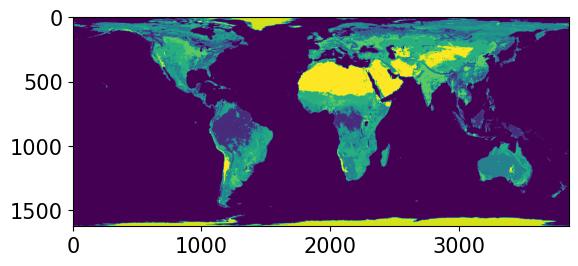

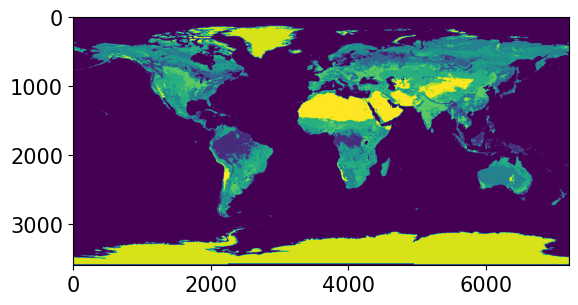

In [9]:
importlib.reload(hData);
LULC_36 = hData.Resampling(lon_36, lat_36, lon_eqd_5km, lat_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=1)
LULC_25 = hData.Resampling(lon_25, lat_25, lon_eqd_5km, lat_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=1)
LULC_9  = hData.Resampling(lon_9,  lat_9,  lon_eqd_5km, lat_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=1)
#LULC_3  = hData.Resampling(lon_3,  lat_3,  lon_eqd_5km, lat_eqd_5km, MCD12C1_t1, sampling_method='nearest', agg_method='mode', mag_factor=5)
plt.imshow(LULC_9)
plt.show()
plt.imshow(MCD12C1_t1)

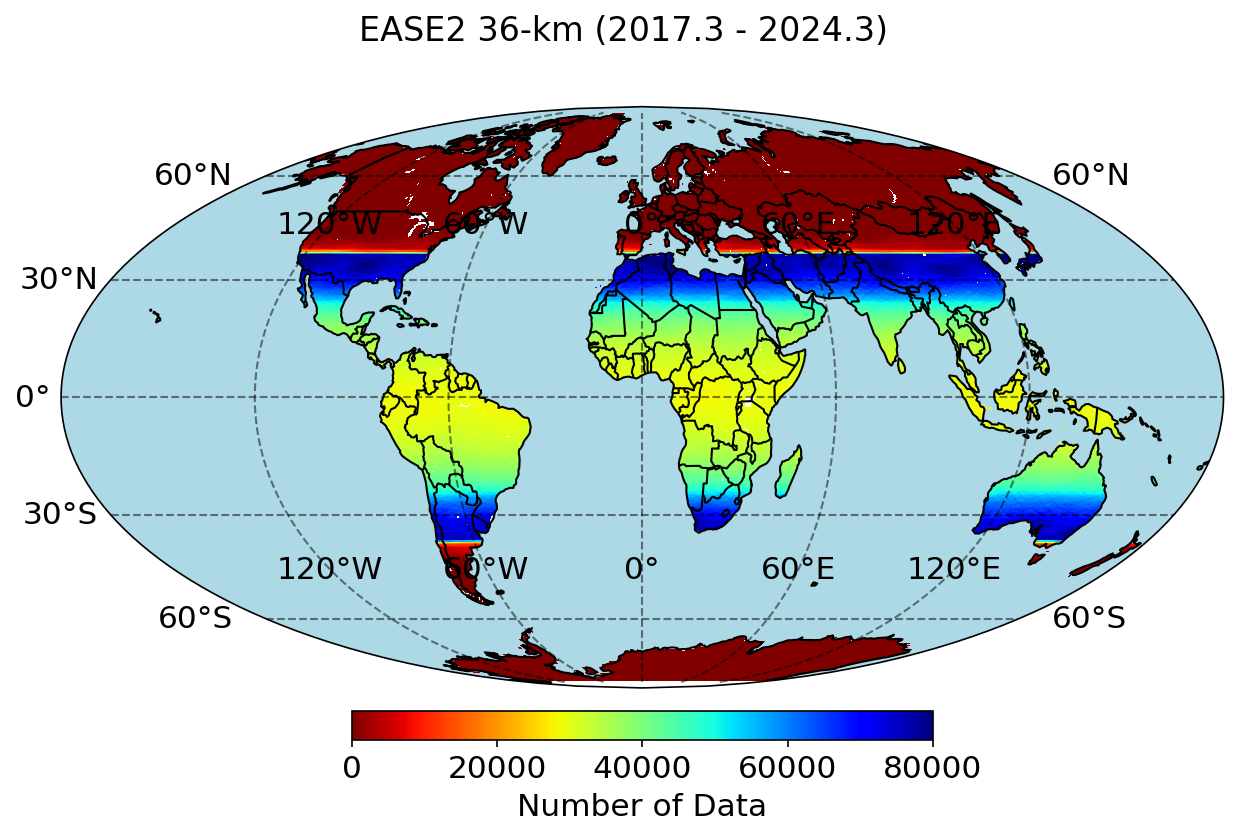

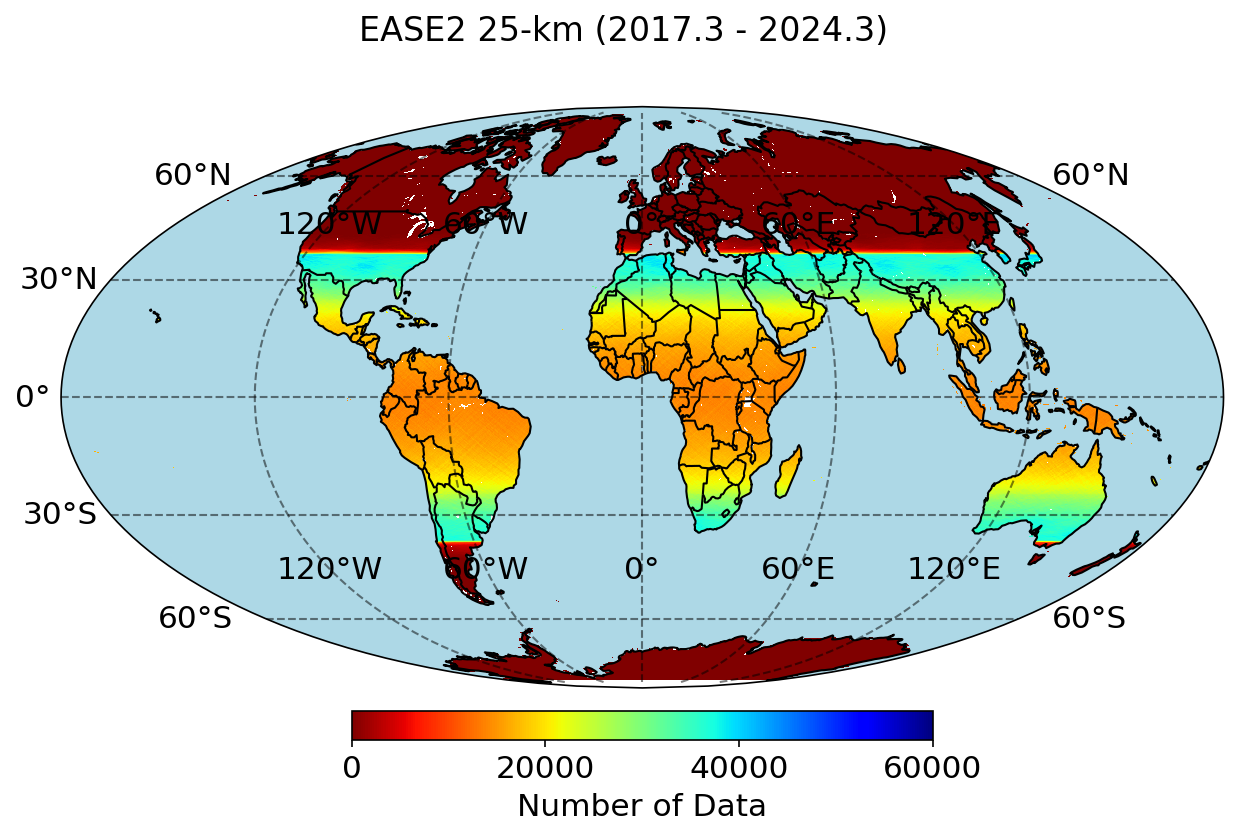

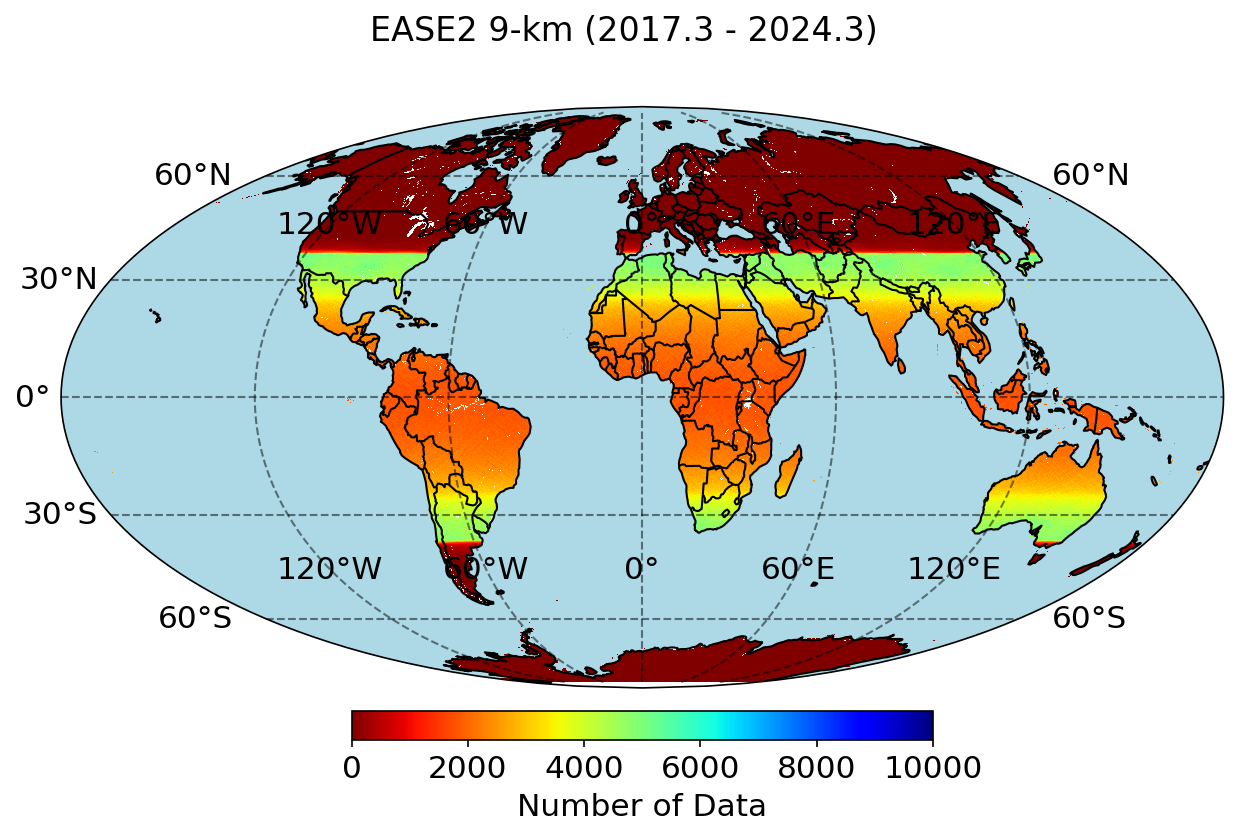

In [10]:
def calculate_and_plot(data_counts, angle_sum, angle_sum_sq, lon, lat, LULC, resol):
    """
    Calculate the inclination angle and standard deviation, then plot the data on a map.

    Args:
    - data_counts: Data counts.
    - angle_sum: Angle sum.
    - angle_sum_sq: Angle sum squared.
    - lon: Longitudes.
    - lat: Latitudes.
    - LULC: Land use land cover data.

    Returns:
    - None
    """
    # Calculate inclination angle average
    with np.errstate(divide='ignore', invalid='ignore'):
        inc_avg = angle_sum / data_counts
        inc_std = angle_sum_sq / data_counts - (angle_sum / data_counts) ** 2
        inc_std[data_counts == 0] = np.nan  # Set where denominator is zero to NaN

    # Prepare data for plotting
    val = data_counts.copy()
    val[LULC == 0] = np.nan

    # Plot the data on a map
    importlib.reload(hPlot)
    if resol == '36':
        max_val = 80000
    elif resol == '25':
        max_val = 60001
    elif resol == '9':
        max_val = 10000
    elif resol == '3':
        max_val = 2000
    
    hPlot.plot_map(lon, lat, val, 0, max_val, plot_title='EASE2 '+resol+'-km (2017.3 - 2024.3)',
                   label_title='Number of Data', cmap='jet_r', projection='Mollweide')

# Example usage:
calculate_and_plot(counts_36, sum_36, sum_sq_36, lon_36, lat_36, LULC_36, '36')
calculate_and_plot(counts_25, sum_25, sum_sq_25, lon_25, lat_25, LULC_25, '25')
calculate_and_plot(counts_9, sum_9, sum_sq_9, lon_9, lat_9, LULC_9, '9')
#calculate_and_plot(counts_3, sum_3, sum_sq_3, lon_3, lat_3, LULC_3, '3')

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_38443/2296761267.py:9: RuntimeWarning: Mean of empty slice
  counts_36_per_day_mean = np.nanmean(counts_36_nan,1)


(-90.0, 90.0)

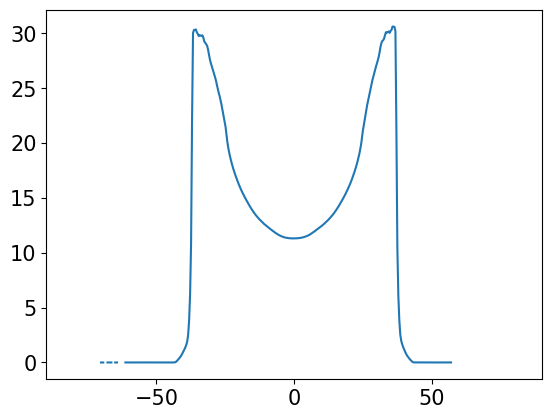

In [82]:
#2017.03.18
#2024.03.19

time_days = (datetime(2024,3,19,0,0)-datetime(2017, 3, 18, 0, 0)).days

counts_36_nan = counts_36.copy()/time_days
counts_36_nan[counts_36 == 0] = np.nan

counts_36_per_day_mean = np.nanmean(counts_36_nan,1)
counts_36_per_day_std = np.nanstd(counts_36_nan,1)

plt.plot(lat_36[:,0], counts_36_per_day_mean)
plt.xlim([-90, 90])

In [71]:
def process_data_SMOS(year, am_pm, base_path):
    filename = f'SMOS_IC_{year}_{am_pm}_R_SPL3SMP.008.nc'
    file_path = os.path.join(base_path, filename)
    try:
        with xr.open_dataset(file_path) as ds:
            # Extract the SMOS_SM variable
            smos_sm = ds['SMOS_SM']
            # Replace non-NaN with 1 (valid data) and NaN with 0
            valid_data = np.where(np.isnan(smos_sm), 0, 1)
            # Sum across the 3rd dimension (time)
            valid_data_sum = np.sum(valid_data, axis=2)
            return valid_data_sum
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
        return None

# Arrays to hold data for all years for 'am' and 'pm'
all_years_am_SMOS = []
all_years_pm_SMOS = []

base_path = cpuserver_data_FP + '/extracted_nc'
# Loop through each year from 2017 to 2022
for year in range(2017, 2023):
    valid_data_am_SMOS = process_data_SMOS(year, 'am', base_path)
    if valid_data_am_SMOS is not None:
        all_years_am_SMOS.append(valid_data_am_SMOS)

    valid_data_pm_SMOS = process_data_SMOS(year, 'pm', base_path)
    if valid_data_pm_SMOS is not None:
        all_years_pm_SMOS.append(valid_data_pm_SMOS)

# Stack and sum up all years for 'am' and 'pm' data separately
total_valid_am_SMOS = np.dstack(all_years_am_SMOS).sum(axis=2)
total_valid_pm_SMOS = np.dstack(all_years_pm_SMOS).sum(axis=2)

In [72]:
def process_data_SMAP(year, am_pm, base_path):
    filename = f'SPL3SMP.008_{year}_{am_pm}.nc'
    file_path = os.path.join(base_path, filename)
    try:
        with xr.open_dataset(file_path) as ds:
            # Extract the smap_SM variable
            if am_pm == 'am':
                smap_sm = ds['soil_moisture']
            elif am_pm == 'pm':
                smap_sm = ds['soil_moisture_pm']
            valid_data = np.where(np.isnan(smap_sm), 0, 1)
            # Sum across the 3rd dimension (time)
            valid_data_sum = np.sum(valid_data, axis=2)
            return valid_data_sum
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")
        return None
        
# Arrays to hold data for all years for 'am' and 'pm'
all_years_am_SMAP = []
all_years_pm_SMAP = []

base_path = cpuserver_data_FP + '/extracted_nc'
# Loop through each year from 2017 to 2022
for year in range(2017, 2023):
    valid_data_am_SMAP = process_data_SMAP(year, 'am', base_path)
    if valid_data_am_SMAP is not None:
        all_years_am_SMAP.append(valid_data_am_SMAP)

    valid_data_pm_SMAP = process_data_SMAP(year, 'pm', base_path)
    if valid_data_pm_SMAP is not None:
        all_years_pm_SMAP.append(valid_data_pm_SMAP)

# Stack and sum up all years for 'am' and 'pm' data separately
total_valid_am_SMAP = np.dstack(all_years_am_SMAP).sum(axis=2)
total_valid_pm_SMAP = np.dstack(all_years_pm_SMAP).sum(axis=2)

In [78]:
time_days = (datetime(2023, 1, 1, 0, 0)-datetime(2017,1,1,0,0)).days
SMAP_per_day = (total_valid_am_SMAP + total_valid_pm_SMAP)/time_days
SMAP_per_day_nan = SMAP_per_day.copy()
SMAP_per_day_nan[SMAP_per_day_nan == 0] = np.nan
SMAP_per_day_mean = np.nanmean(SMAP_per_day_nan, 1)
SMAP_per_day_std = np.nanstd(SMAP_per_day_nan, 1)

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_38443/725489880.py:5: RuntimeWarning: Mean of empty slice
  SMAP_per_day_mean = np.nanmean(SMAP_per_day_nan, 1)


In [77]:
time_days = (datetime(2023, 1, 1, 0, 0)-datetime(2017,1,1,0,0)).days
SMOS_per_day = (total_valid_am_SMOS + total_valid_pm_SMOS)/time_days
SMOS_per_day_nan = SMOS_per_day.copy()
SMOS_per_day_nan[SMOS_per_day_nan == 0] = np.nan
SMOS_per_day_mean = np.nanmean(SMOS_per_day_nan, 1)
SMOS_per_day_std = np.nanstd(SMOS_per_day_nan, 1)



/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_38443/529666065.py:5: RuntimeWarning: Mean of empty slice
  SMOS_per_day_mean = np.nanmean(SMOS_per_day_nan, 1)


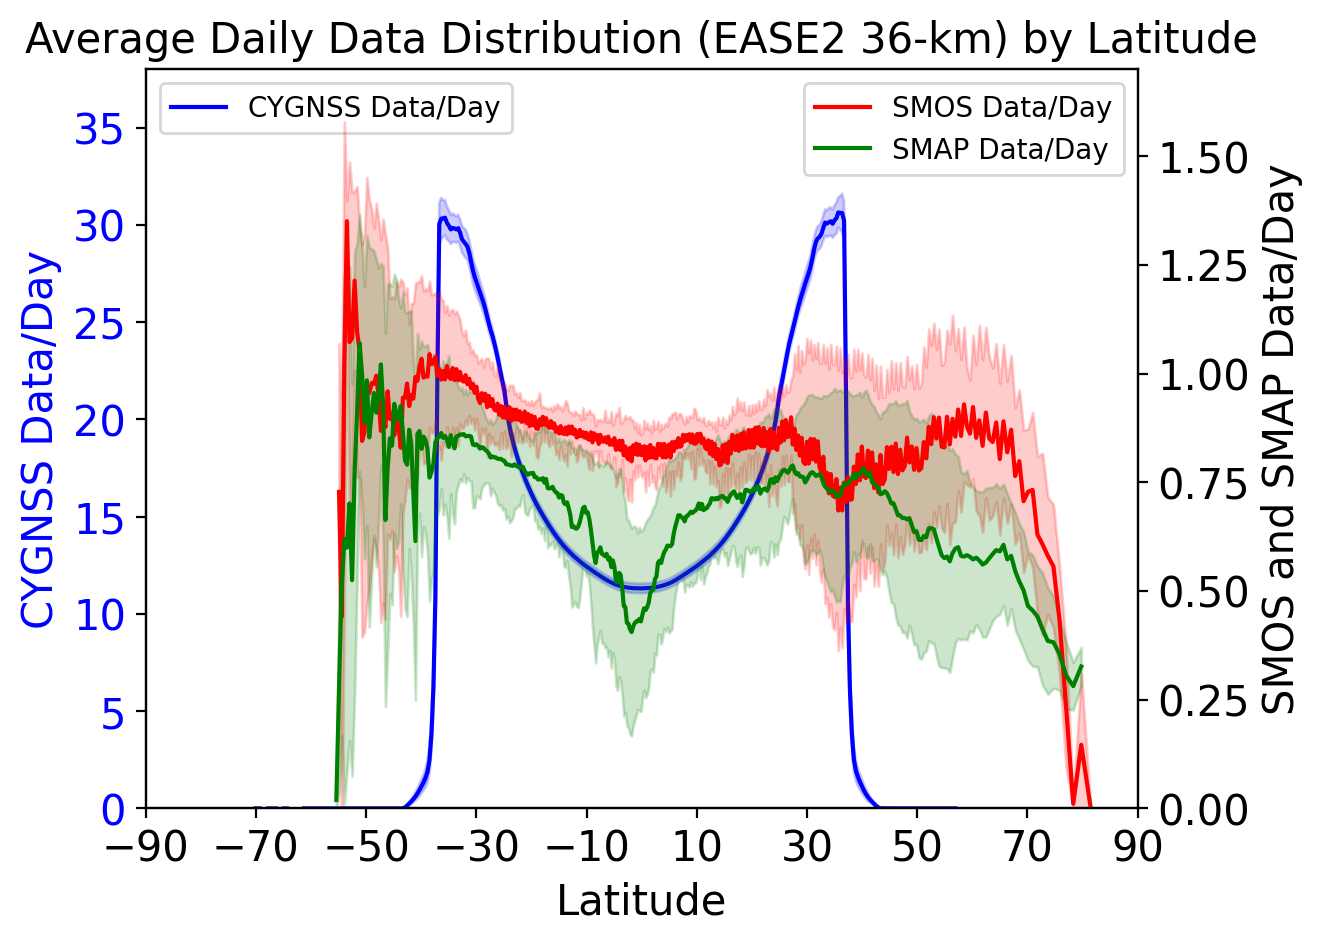

In [98]:
# Create a figure and an axes.
fig, ax1 = plt.subplots(dpi=200)

# Plot counts on the left y-axis
ax1.plot(lat_36[:,0], counts_36_per_day_mean, 'b-', label='CYGNSS Data/Day')
ax1.fill_between(lat_36[:,0], counts_36_per_day_mean - counts_36_per_day_std,
                 counts_36_per_day_mean + counts_36_per_day_std, color='b', alpha=0.2)
ax1.set_xlabel('Latitude')
ax1.set_ylabel('CYGNSS Data/Day', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlim([-90, 90])
ax1.set_ylim([0, 38])

# Set more specific x-ticks at intervals of 10 from -90 to 90
ax1.set_xticks(np.arange(-90, 91, 20))

# Create a second y-axis for the SMOS and SMAP data
ax2 = ax1.twinx()
ax2.plot(lat_36[:,0], SMOS_per_day_mean, 'r-', label='SMOS Data/Day')
ax2.fill_between(lat_36[:,0], SMOS_per_day_mean - SMOS_per_day_std,
                 SMOS_per_day_mean + SMOS_per_day_std, color='r', alpha=0.2)
ax2.plot(lat_36[:,0], SMAP_per_day_mean, 'g-', label='SMAP Data/Day')
ax2.fill_between(lat_36[:,0], SMAP_per_day_mean - SMAP_per_day_std,
                 SMAP_per_day_mean + SMAP_per_day_std, color='g', alpha=0.2)
ax2.set_ylabel('SMOS and SMAP Data/Day', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Optionally, you can add a legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.set_xlim([-90, 90])
ax2.set_ylim([0, 1.7])

# Add a title to the plot
plt.title('Average Daily Data Distribution (EASE2 36-km) by Latitude')

# Show the plot
plt.show()

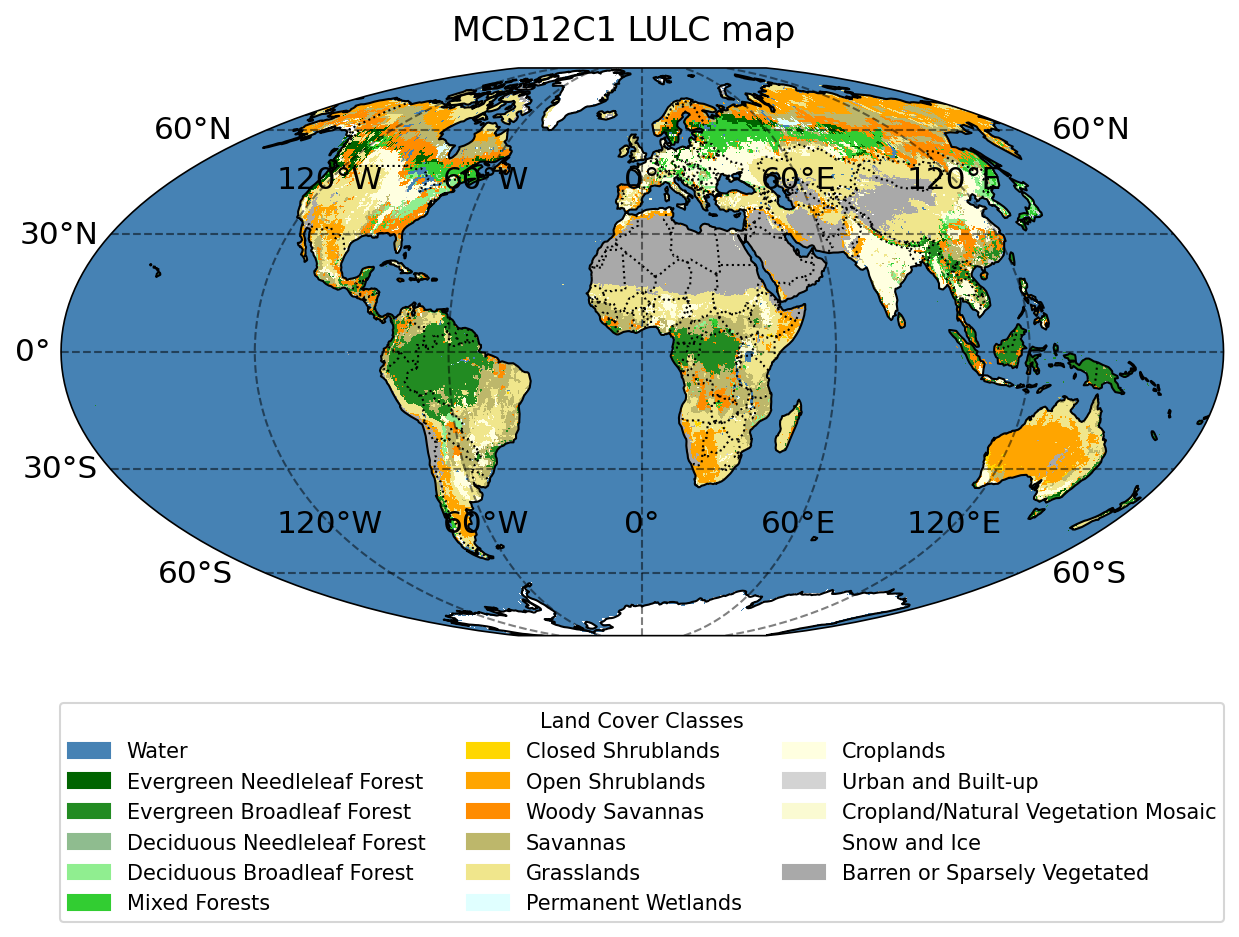

In [162]:
importlib.reload(hPlot)
#hPlot.plot_LULC_map_MCD12C1(lon_3, lat_3, LULC_3)
hPlot.plot_LULC_map_MCD12C1(lon_36, lat_36, LULC_36)

In [12]:
nc_save_dir = cpuserver_data_FP + '/extracted_nc'
mission_product = 'SPL3SMP.008'

start_year = 2015
end_year = 2023

SM = np.array([])
VWC = np.array([])

for year in range(start_year, end_year + 1):
    # Define the file name based on the year and path
    path = 'am'  # Assuming 'am' or 'pm'; adjust logic if it varies yearly
    nc_file = f"{nc_save_dir}/{mission_product}_{year}_{path}.nc"
    
    # Open the NetCDF file
    nc_data = nc.Dataset(nc_file)

    # Load data based on the time of day ('am' or 'pm')
    if path == 'pm':
        SMAP_SM = nc_data.variables[f'soil_moisture_{path}'][:].data
        SMAP_VWC = nc_data.variables[f'vegetation_water_content_{path}'][:].data
    else:
        SMAP_SM = nc_data.variables['soil_moisture'][:].data
        SMAP_VWC = nc_data.variables['vegetation_water_content'][:].data
    
    # Stack the arrays from each year
    if SM.size == 0:  # If the SM array is empty, initialize it
        SM = SMAP_SM
        VWC = SMAP_VWC
    else:  # Otherwise, stack the new data onto the existing array
        SM = np.dstack((SM, SMAP_SM))
        VWC = np.dstack((VWC, SMAP_VWC))
        
    if year == start_year:
        SMAP_lat = nc_data.variables['latitude'][:].data
        SMAP_lon = nc_data.variables['longitude'][:].data
    
    # Close the NetCDF file
    nc_data.close()

In [163]:
avg_VWC = np.nanmean(VWC,axis=2)
avg_SM = np.nanmean(SM, axis=2)
VWC = []
SM = []
SMAP_SM = []
SMAP_VWC=[]

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/25291674.py:1: RuntimeWarning: Mean of empty slice
  avg_VWC = np.nanmean(VWC,axis=2)
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/25291674.py:2: RuntimeWarning: Mean of empty slice
  avg_SM = np.nanmean(SM, axis=2)


In [164]:
avg_VWC_3 = hData.Resampling(lon_3,  lat_3,  lon_36, lat_36, avg_VWC, sampling_method='nearest', agg_method='mean', mag_factor=5)

NameError: name 'lon_3' is not defined

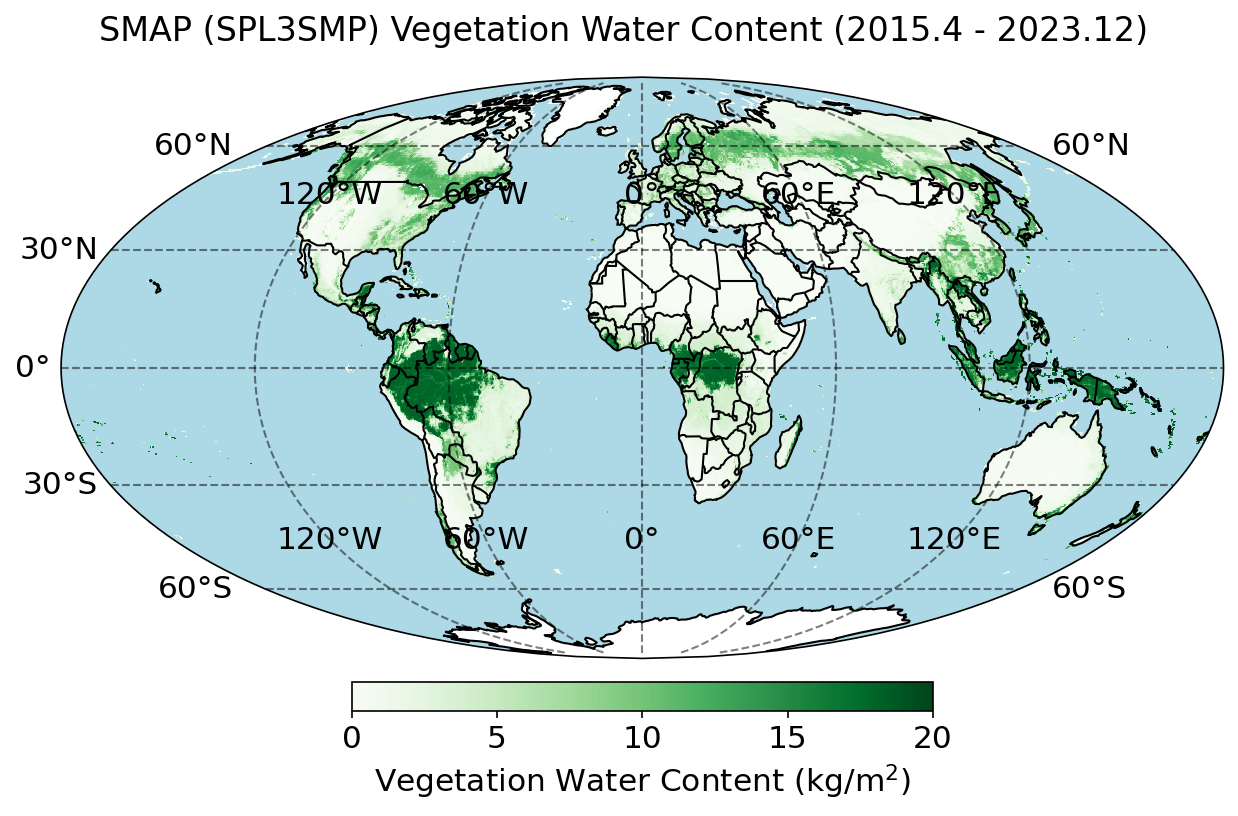

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [169]:
hPlot.plot_map(SMAP_lon, SMAP_lat, avg_VWC, 0, 20, plot_title='SMAP (SPL3SMP) Vegetation Water Content (2015.4 - 2023.12)', label_title='Vegetation Water Content (kg/m$^{2}$)', cmap='Greens', projection='Mollweide')

In [53]:
def save_variables_hdf5(filename):
    # Create an HDF5 file
    with h5py.File(filename, 'w') as h5f:
        # Scan all variables in the global scope
        for name, value in globals().items():
            # Filter out module imports, functions, and built-ins
            if not name.startswith('__') and not callable(value) and not isinstance(value, ModuleType):
                # Check if value is of a type supported by HDF5
                if isinstance(value, (np.ndarray, list, tuple, int, float, str, bool)):
                    try:
                        # Create a dataset for each variable
                        h5f.create_dataset(name, data=value)
                        print(f'Saved {name}: type {type(value)}')
                    except TypeError as e:
                        print(f'Could not save {name}: unsupported type ({type(value)}) due to {e}')
                else:
                    print(f'Skipped {name}: unsupported type ({type(value)})')

filename = cpuserver_data_FP + "/Ex_in_CYGNSS_variables.h5"
save_variables_hdf5(filename)

Saved _ih: type <class 'numpy.ndarray'>
Skipped _oh: unsupported type (<class 'dict'>)
Could not save _dh: unsupported type (<class 'list'>) due to Object dtype dtype('O') has no native HDF5 equivalent
Saved In: type <class 'numpy.ndarray'>
Skipped Out: unsupported type (<class 'dict'>)
Could not save _: unsupported type (<class 'tuple'>) due to Object dtype dtype('O') has no native HDF5 equivalent
Saved _i: type <class 'str'>
Saved _ii: type <class 'str'>
Saved _iii: type <class 'str'>
Saved _i1: type <class 'numpy.ndarray'>
Saved base_FP: type <class 'str'>
Saved cpuserver_data_FP: type <class 'str'>
Saved _i2: type <class 'numpy.ndarray'>
Saved base_dir: type <class 'str'>
Saved nc_file_list: type <class 'list'>
Saved _i3: type <class 'numpy.ndarray'>
Saved ref_lon: type <class 'numpy.ndarray'>
Saved ref_lat: type <class 'numpy.ndarray'>
Saved data_count: type <class 'numpy.ndarray'>
Saved ref_points: type <class 'numpy.ndarray'>
Skipped tree: unsupported type (<class 'scipy.spatial

In [46]:
def load_variables_from_hdf5(filename):
    with h5py.File(filename, 'r') as h5f:
        # Iterate over every item in the file, which are datasets in your case
        for name, data in h5f.items():
            # Assign the data to a global variable with the same name
            globals()[name] = np.array(data)  # Convert to numpy array if not already

load_variables_from_hdf5(filename)

In [108]:
#0 - 16
counts_LULC_36_dic = {}
counts_LULC_3_dic = {}

for i in range(1, 17):
    # Extract counts from counts_36 where the corresponding LULC_36 is equal to i
    counts_LULC_36_dic[i] = counts_36[LULC_36 == i]
    
counts_LULC_3_dic = {}
for i in range(1, 17):
    # Extract counts from counts_3 where the corresponding LULC_3 is equal to i
    counts_LULC_3_dic[i] = counts_3[LULC_3 == i]

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_71080/3570386420.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


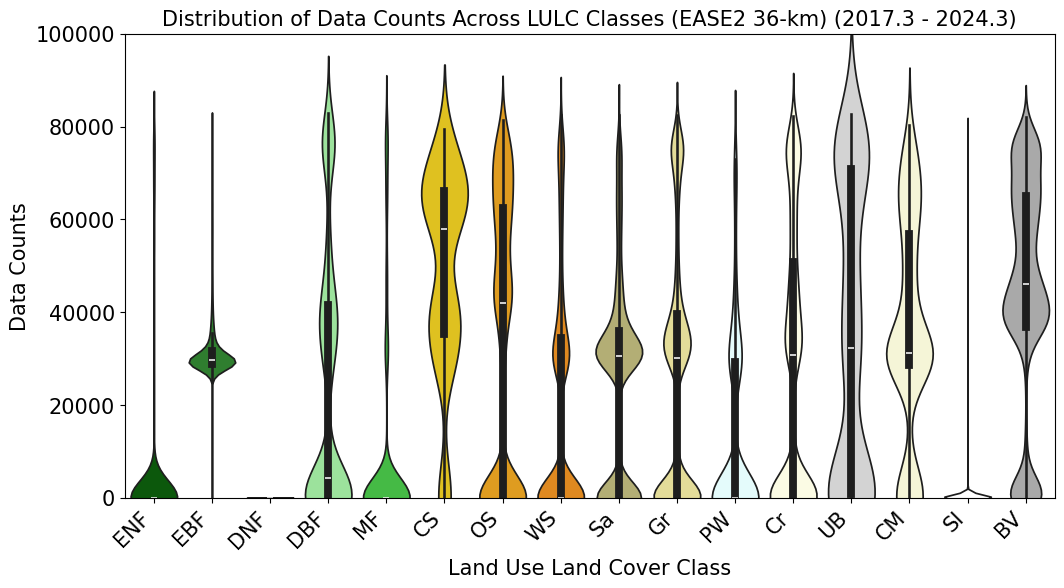

In [128]:
# Given LULC descriptions and colors
lulc_types = {
    0: ('Water', '#4682B4'),
    1: ('ENF', '#006400'), # Evergreen Needleleaf Forest
    2: ('EBF', '#228B22'), # Evergreen Broadleaf Forest
    3: ('DNF', '#8FBC8F'), # Deciduous Needleleaf Forest
    4: ('DBF', '#90EE90'), # Deciduous Broadleaf Forest
    5: ('MF', '#32CD32'),  # Mixed Forests
    6: ('CS', '#FFD700'),  # Closed Shrublands
    7: ('OS', '#FFA500'),  # Open Shrublands
    8: ('WS', '#FF8C00'),  # Woody Savannas
    9: ('Sa', '#BDB76B'),  # Savannas
    10: ('Gr', '#F0E68C'), # Grasslands
    11: ('PW', '#E0FFFF'), # Permanent Wetlands
    12: ('Cr', '#FFFFE0'), # Croplands
    13: ('UB', '#D3D3D3'), # Urban and Built-up
    14: ('CM', '#FAFAD2'), # Cropland/Natural Vegetation Mosaic
    15: ('SI', '#FFFFFF'), # Snow and Ice
    16: ('BV', '#A9A9A9')  # Barren or Sparsely Vegetated
}

# Assuming 'counts_LULC_36_dic' is already defined and populated
# Each key in counts_LULC_36_dic corresponds to an index in lulc_types

# Prepare the data for plotting
data_to_plot = [counts_LULC_36_dic.get(i, []) for i in range(1, 17)]  # Adjusted to match LULC types' keys starting from 1 to 16
labels = [lulc_types[i][0] for i in range(1, 17)]
colors = [lulc_types[i][1] for i in range(1, 17)]

# Create the violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=data_to_plot, palette=colors, density_norm='width')

# Customizing the plot
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.title('Distribution of Data Counts Across LULC Classes (EASE2 36-km) (2017.3 - 2024.3)')
plt.ylabel('Data Counts')
plt.xlabel('Land Use Land Cover Class')
plt.ylim([0, 100000])
# Adjust layout to prevent clipping of tick-labels
plt.gcf().subplots_adjust(bottom=0.3)

# Show the plot
plt.show()

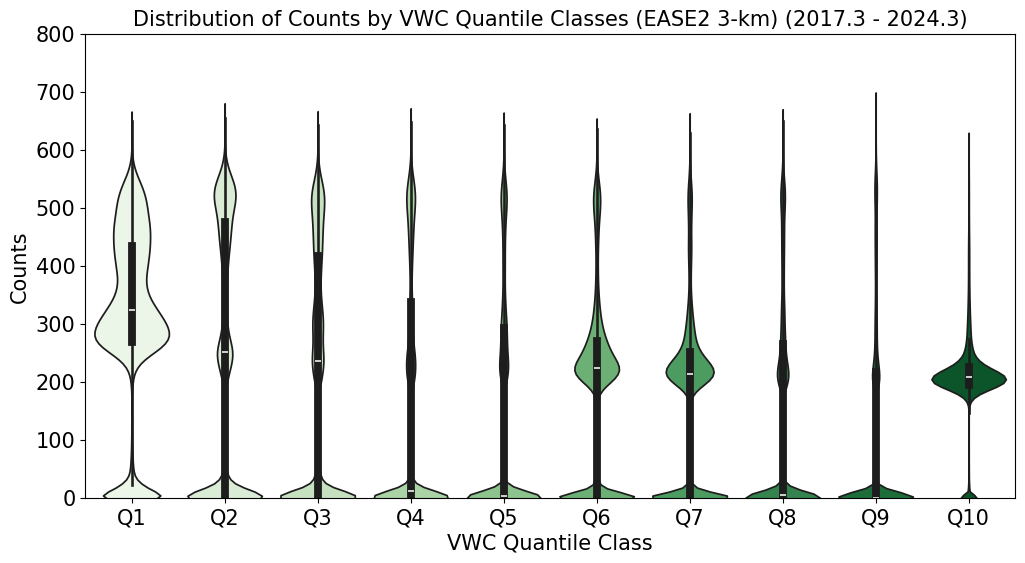

In [127]:
# Convert the VWC data into a DataFrame for easier manipulation
vwc_df = pd.DataFrame(avg_VWC_3.flatten(), columns=['VWC'])

# Create VWC classes based on quantiles
vwc_df['VWC_Class'] = pd.qcut(vwc_df['VWC'], 10, labels=False) + 1  # Labels from 1 to 10

# Join this back to your counts data if needed, assuming you have a similar index
counts_36_df = pd.DataFrame(counts_3.flatten(), columns=['Counts'])  # Assuming counts_36 is your counts data
combined_df = pd.concat([counts_36_df, vwc_df['VWC_Class']], axis=1)

# Dictionary to hold counts data for each VWC class
counts_VWC_classes_dic = {}

# Populate the dictionary with counts data categorized by VWC classes
for i in range(1, 11):
    counts_VWC_classes_dic[i] = combined_df['Counts'][combined_df['VWC_Class'] == i].values

data_to_plot = [counts_VWC_classes_dic[i] for i in range(1, 11)]

palette = sns.color_palette("Greens", n_colors=10)

# Plotting the violin plot with the custom Greens palette
plt.figure(figsize=(12, 8))
sns.violinplot(data=data_to_plot, palette=palette, density_norm='width')
plt.title('Distribution of Counts by VWC Quantile Classes (EASE2 3-km) (2017.3 - 2024.3)')
plt.xlabel('VWC Quantile Class')
plt.ylabel('Counts')
plt.ylim([0, 800])
plt.xticks(ticks=range(10), labels=[f'Q{i}' for i in range(1, 11)])
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()

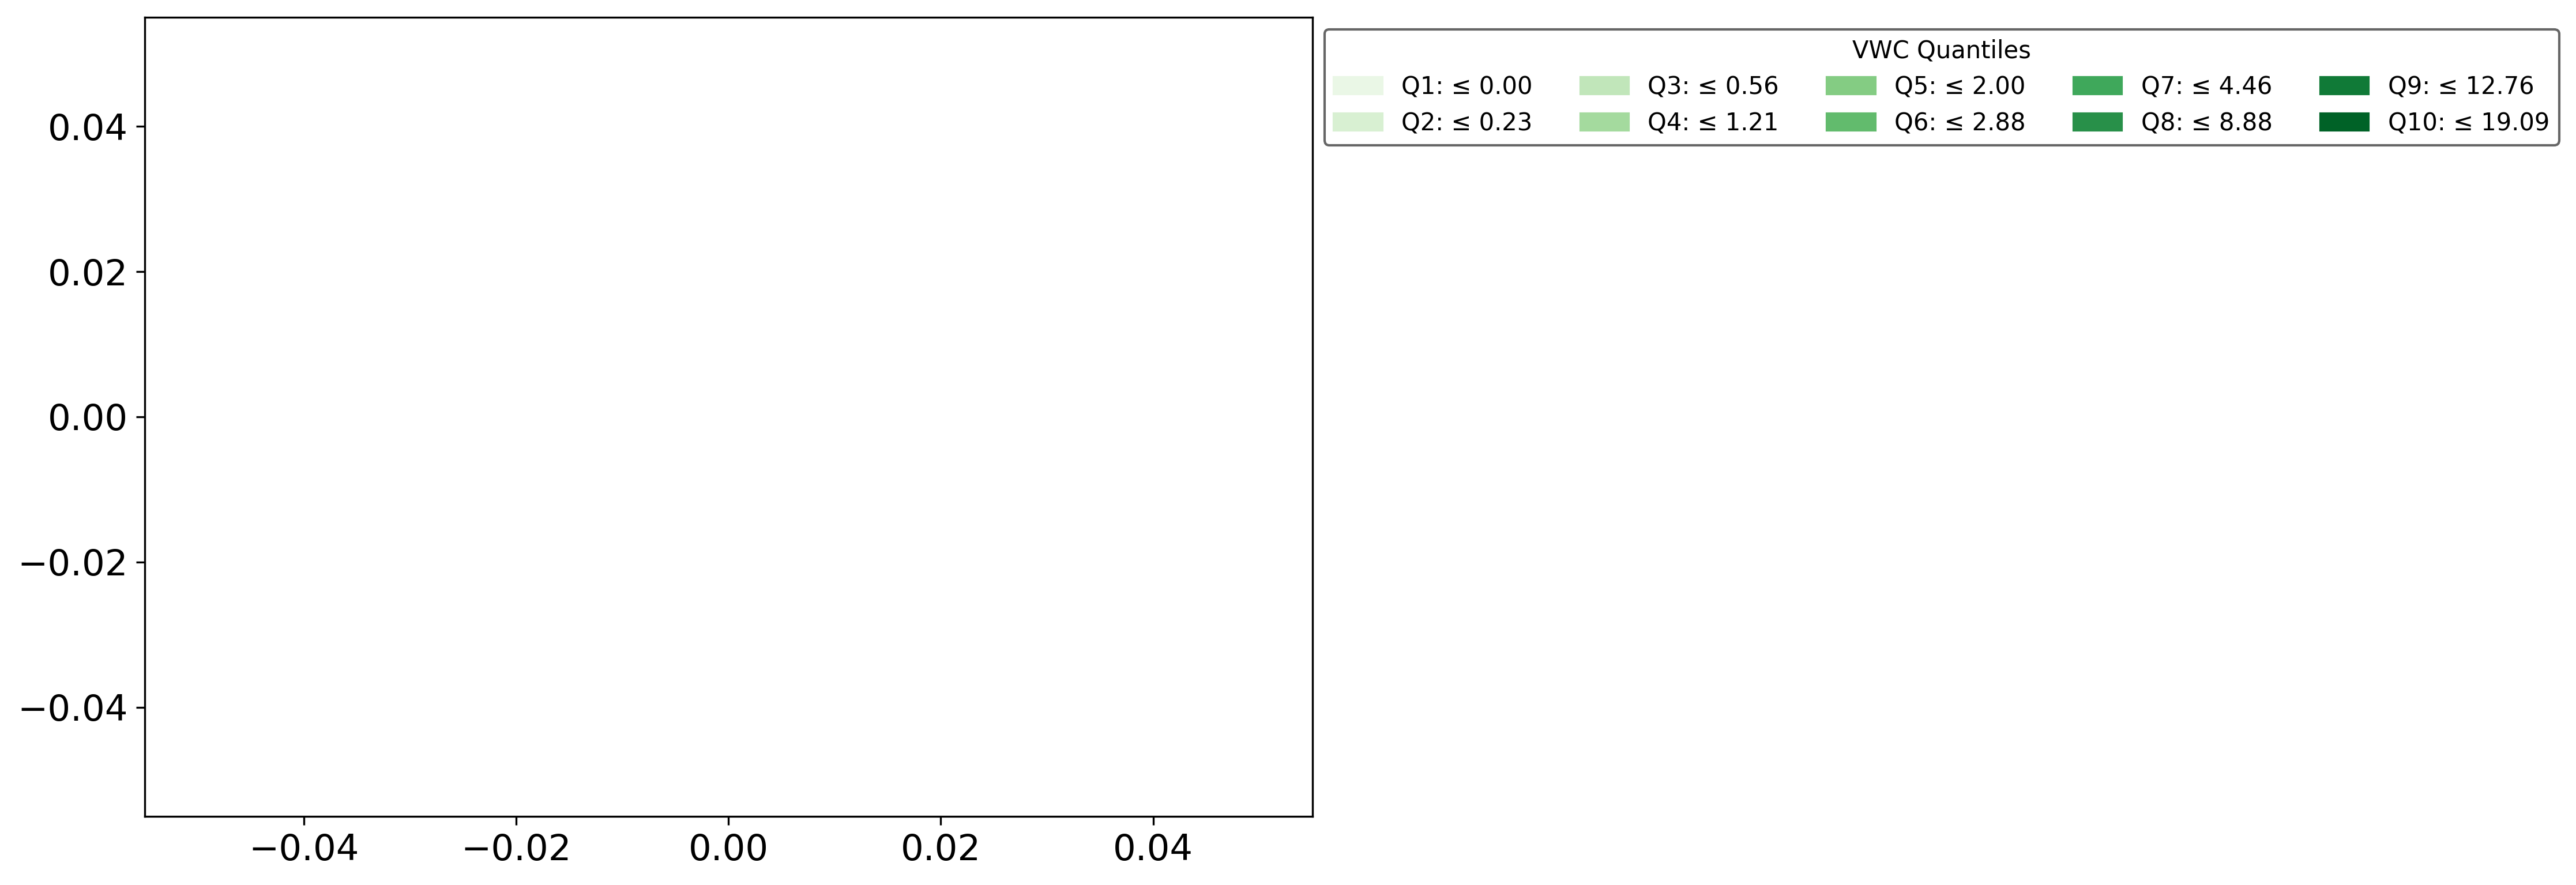

In [126]:
# Assuming avg_VWC is your array of VWC data
quantile_values = np.nanquantile(avg_VWC.flatten(), np.linspace(0.1, 1, 10))  # From 10% to 100%

# Generate a Greens color palette with 10 distinct colors
palette = sns.color_palette("Greens", n_colors=10)

# Create labels for each quantile
labels = [f'Q{i+1}: ≤ {quantile_values[i]:.2f}' for i in range(10)]

# Create a list of patches for the legend
patches = [mpatches.Patch(color=palette[i], label=labels[i]) for i in range(10)]

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Optional dummy plot for illustration
for i, color in enumerate(palette):
    ax.plot([], [], color=color)  # Creates dummy lines for visualization purposes

# Add the legend to the plot with custom settings
legend = ax.legend(handles=patches, title="VWC Quantiles", loc='upper left', bbox_to_anchor=(1, 1),
                   frameon=True, framealpha=0.6, edgecolor='black', fancybox=True, shadow=False, ncol=5)

# Adjust the layout to make space for the legend
plt.subplots_adjust(right=0.8)  # Adjust this value based on your actual plot dimensions

# Display the plot
plt.show()


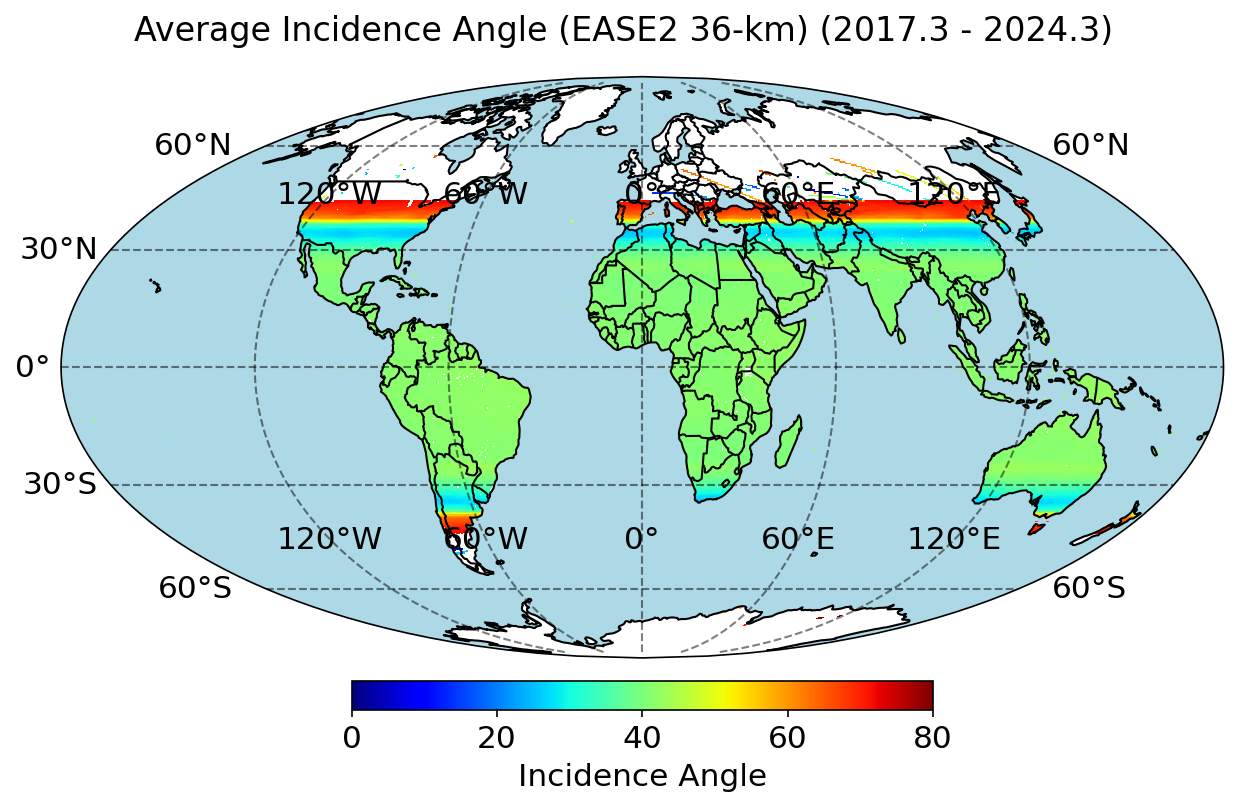

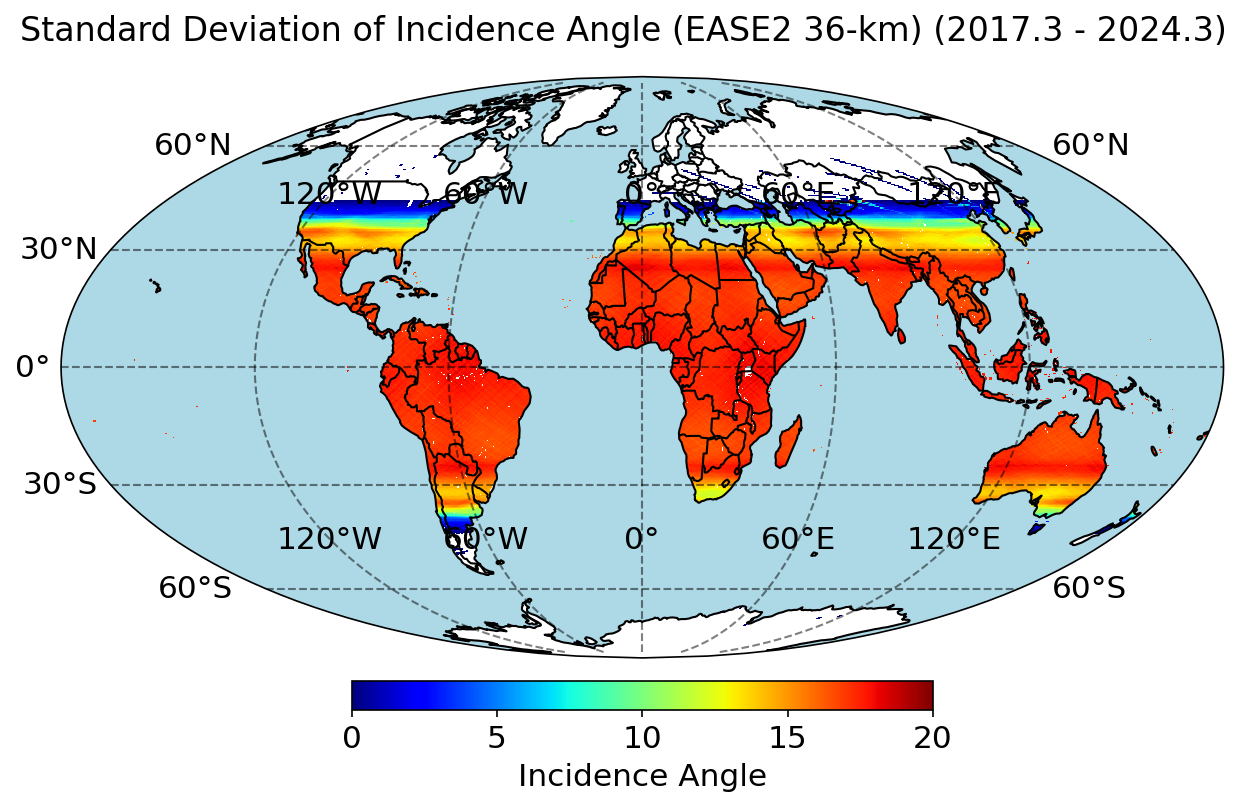

In [142]:
def calculate_and_plot(data_counts, angle_sum, angle_sum_sq, lon, lat, LULC, resol, val='inc_avg'):
    """
    Calculate the inclination angle and standard deviation, then plot the data on a map.

    Args:
    - data_counts: Data counts.
    - angle_sum: Angle sum.
    - angle_sum_sq: Angle sum squared.
    - lon: Longitudes.
    - lat: Latitudes.
    - LULC: Land use land cover data.

    Returns:
    - None
    """
    # Calculate inclination angle average
    with np.errstate(divide='ignore', invalid='ignore'):
        inc_avg = angle_sum / data_counts
        inc_std = (angle_sum_sq / data_counts - (angle_sum / data_counts) ** 2)**0.5
        inc_std[data_counts == 0] = np.nan  # Set where denominator is zero to NaN

    # Prepare data for plotting
    if val == 'inc_avg':
        title = 'Average'
        val = inc_avg.copy()
        val[LULC == 0] = np.nan
    
        # Plot the data on a map
        importlib.reload(hPlot)
        if resol == '36':
            max_val = 80
        elif resol == '25':
            max_val = 80
        elif resol == '9':
            max_val = 80
        elif resol == '3':
            max_val = 80
    else:
        title = 'Standard Deviation of'
        val = inc_std.copy()
        val[LULC == 0] = np.nan
    
        # Plot the data on a map
        importlib.reload(hPlot)
        if resol == '36':
            max_val = 20
        elif resol == '25':
            max_val = 10
        elif resol == '9':
            max_val = 10
        elif resol == '3':
            max_val = 10
    hPlot.plot_map(lon, lat, val, 0, max_val, plot_title= title+' Incidence Angle (EASE2 '+resol+'-km) (2017.3 - 2024.3)',
                   label_title='Incidence Angle', cmap='jet', projection='Mollweide')

# Example usage:
# Assuming you have the necessary inputs defined
calculate_and_plot(counts_36, sum_36, sum_sq_36, lon_36, lat_36, LULC_36, '36')
calculate_and_plot(counts_36, sum_36, sum_sq_36, lon_36, lat_36, LULC_36, '36', val='inc_std')

In [202]:
x = 30
inc_avg = sum_36 / counts_36
inc_std = (sum_sq_36 / counts_36 - (sum_36 / counts_36) ** 2)**0.5
inc_std[counts_36 == 0] = np.nan  # Set where denominator is zero to NaN

# Calculate the CDF for each grid point
cdf_values = norm.cdf(x, inc_avg, inc_std)

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/1876937516.py:2: RuntimeWarning: invalid value encountered in divide
  inc_avg = sum_36 / counts_36
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/1876937516.py:3: RuntimeWarning: invalid value encountered in divide
  inc_std = (sum_sq_36 / counts_36 - (sum_36 / counts_36) ** 2)**0.5
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/1876937516.py:3: RuntimeWarning: invalid value encountered in sqrt
  inc_std = (sum_sq_36 / counts_36 - (sum_36 / counts_36) ** 2)**0.5
/opt/homebrew/Caskroom/miniforge/base/envs/hydroai/lib/python3.12/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


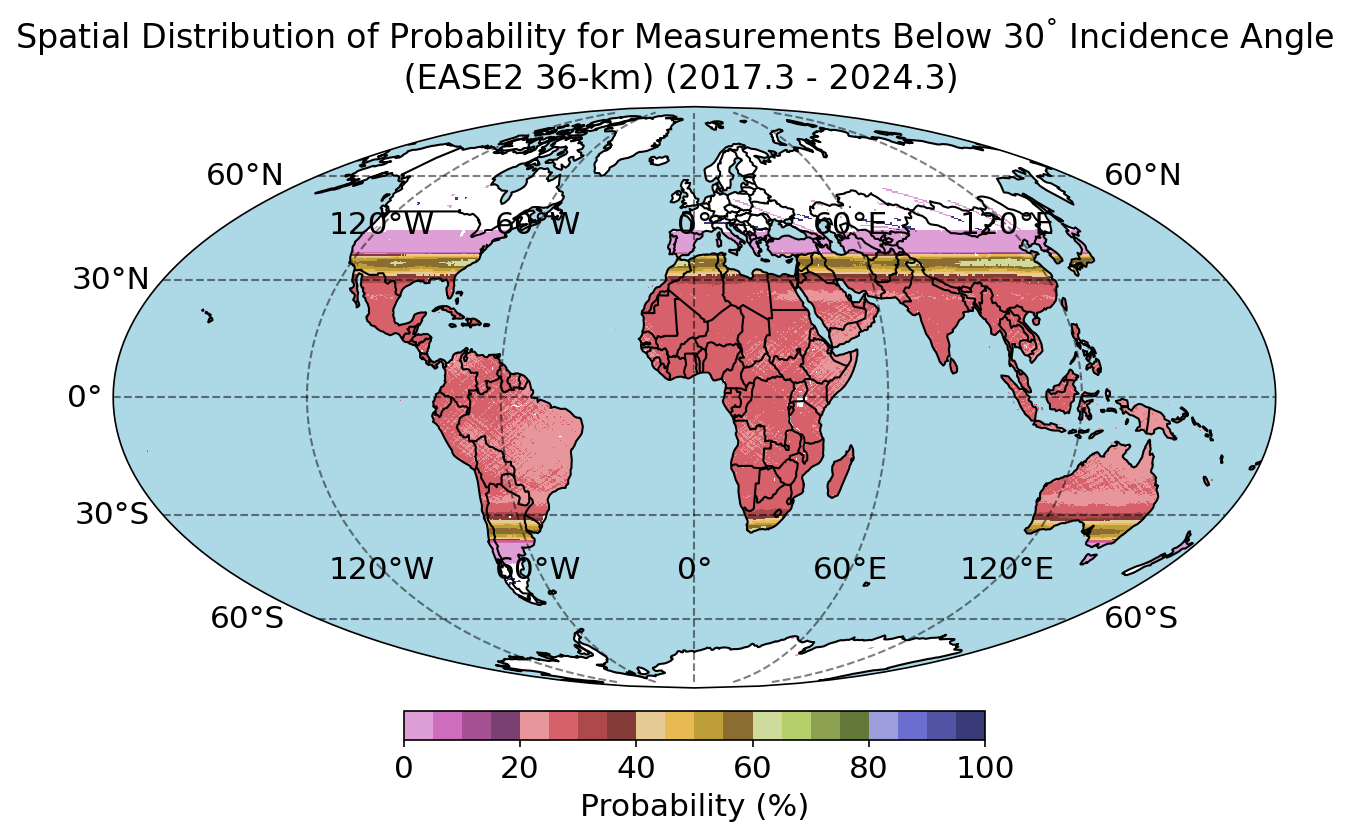

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [203]:
importlib.reload(hPlot)
val = cdf_values.copy()*100
val[LULC_36 == 0] = np.nan
hPlot.plot_map(lon_36, lat_36, val, 0, 100, plot_title= 'Spatial Distribution of Probability for Measurements Below $30^°$ Incidence Angle \n (EASE2 36-km) (2017.3 - 2024.3)', 
               label_title='Probability (%)', cmap='tab20b_r', projection='Mollweide')

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_71080/8597906.py:1: RuntimeWarning: invalid value encountered in divide
  inc_avg_VWC = (sum_36 / counts_36) * avg_VWC
/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_71080/8597906.py:3: RuntimeWarning: divide by zero encountered in divide
  hPlot.plot_map(lon_36, lat_36, 1/inc_avg_VWC, 0, 0.08, plot_title= 'Reliability Map of Soil Moisture Retrieval from CYGNSS Data \n (EASE2 36-km) (2017.3 - 2024.3)',


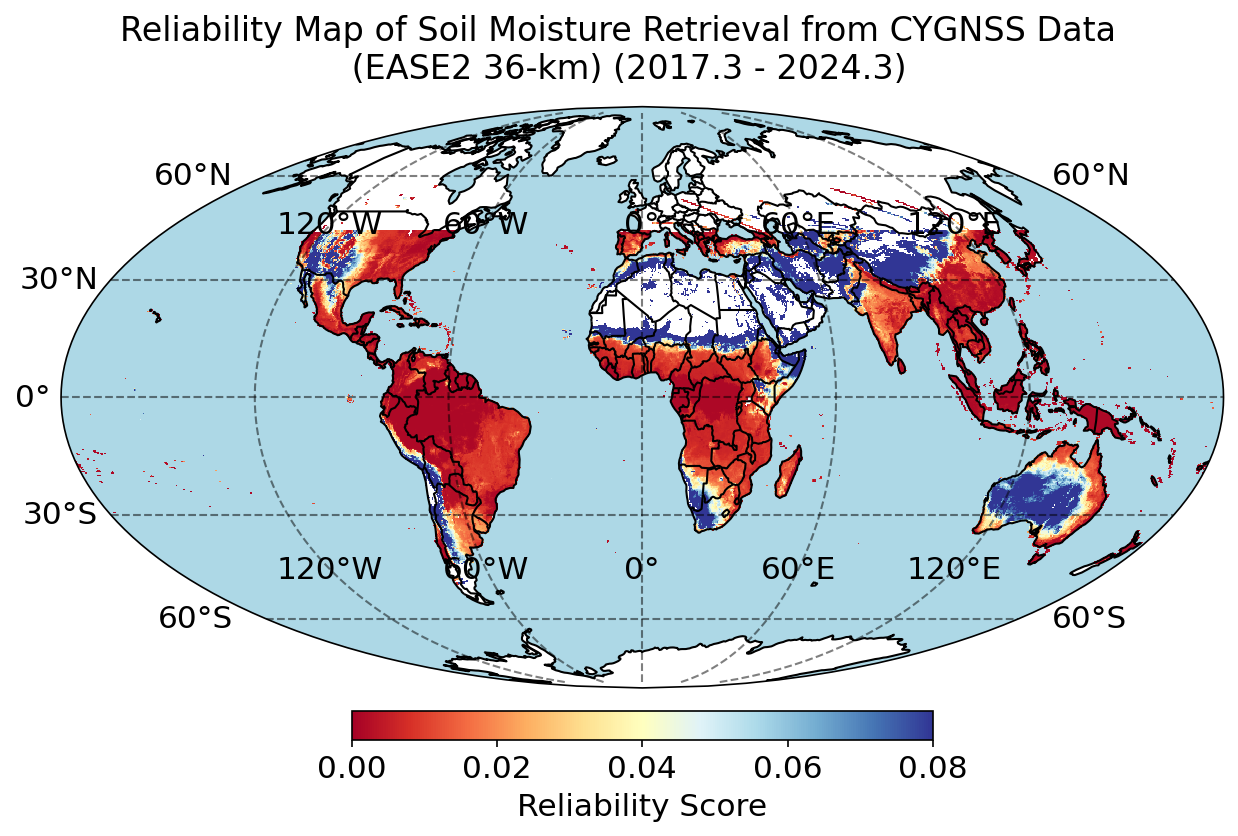

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [257]:
inc_avg_VWC = (sum_36 / counts_36) * avg_VWC
importlib.reload(hPlot)
hPlot.plot_map(lon_36, lat_36, 1/inc_avg_VWC, 0, 0.08, plot_title= 'Reliability Map of Soil Moisture Retrieval from CYGNSS Data \n (EASE2 36-km) (2017.3 - 2024.3)', 
               label_title='Reliability Score', cmap='RdYlBu', projection='Mollweide')

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_71080/4021175286.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=45, ha='right')


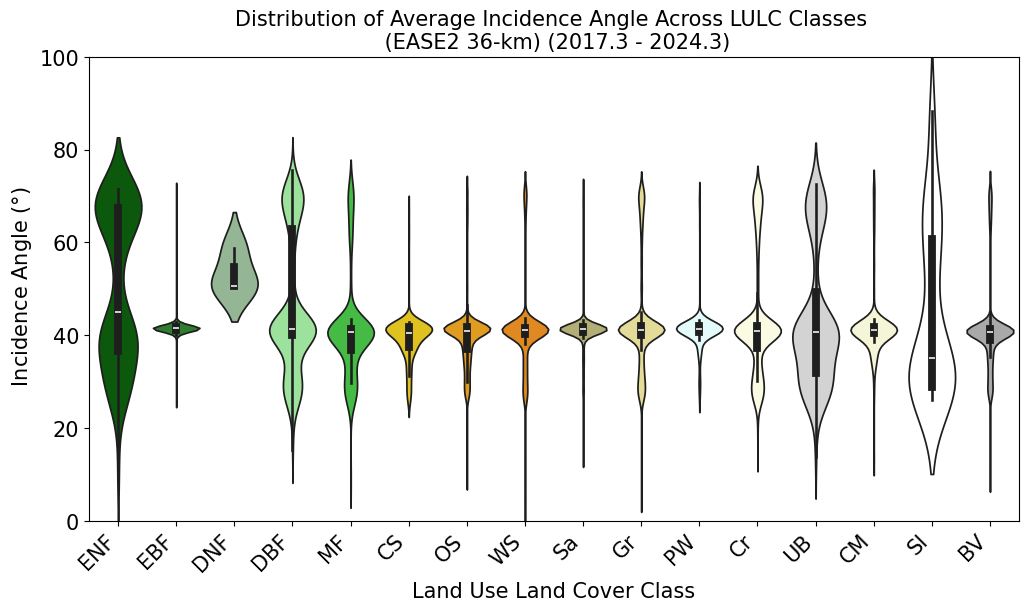

In [278]:
#0 - 16
inc_avg_LULC_36_dic = {}

for i in range(1, 17):
    # Extract counts from inc_36 where the corresponding LULC_36 is equal to i
    inc_avg_LULC_36_dic[i] = inc_avg[LULC_36 == i]
    
# Prepare the data for plotting
data_to_plot = [inc_avg_LULC_36_dic.get(i, []) for i in range(1, 17)]  # Adjusted to match LULC types' keys starting from 1 to 16
labels = [lulc_types[i][0] for i in range(1, 17)]
colors = [lulc_types[i][1] for i in range(1, 17)]

# Create the violin plot
plt.figure(figsize=(12, 8))
ax = sns.violinplot(data=data_to_plot, palette=colors, density_norm='width')

# Customizing the plot
ax.set_xticklabels(labels, rotation=45, ha='right')
plt.title('Distribution of Average Incidence Angle Across LULC Classes \n (EASE2 36-km) (2017.3 - 2024.3)')
plt.ylabel(' Incidence Angle $(°)$')
plt.xlabel('Land Use Land Cover Class')
plt.ylim([0, 100])
# Adjust layout to prevent clipping of tick-labels
plt.gcf().subplots_adjust(bottom=0.3)

# Show the plot
plt.show()

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_71080/3271323927.py:2: RuntimeWarning: invalid value encountered in divide
  inc_avg = (sum_36 / counts_36)


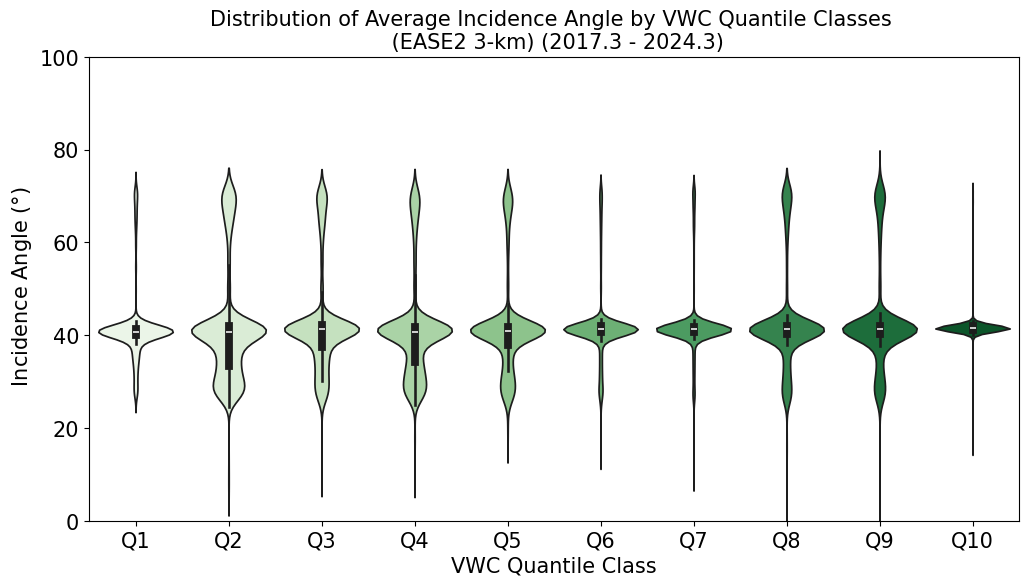

In [275]:
# Convert the VWC data into a DataFrame for easier manipulation
inc_avg = (sum_36 / counts_36)
vwc_df = pd.DataFrame(avg_VWC.flatten(), columns=['VWC'])

# Create VWC classes based on quantiles
vwc_df['VWC_Class'] = pd.qcut(vwc_df['VWC'], 10, labels=False) + 1  # Labels from 1 to 10

# Join this back to your counts data if needed, assuming you have a similar index
inc_avg_36_df = pd.DataFrame(inc_avg.flatten(), columns=['inc_avg'])  # Assuming counts_36 is your counts data
combined_df = pd.concat([inc_avg_36_df, vwc_df['VWC_Class']], axis=1)

# Dictionary to hold counts data for each VWC class
inc_avg_VWC_classes_dic = {}

# Populate the dictionary with counts data categorized by VWC classes
for i in range(1, 11):
    inc_avg_VWC_classes_dic[i] = combined_df['inc_avg'][combined_df['VWC_Class'] == i].values

data_to_plot = [inc_avg_VWC_classes_dic[i] for i in range(1, 11)]

palette = sns.color_palette("Greens", n_colors=10)

# Plotting the violin plot with the custom Greens palette
plt.figure(figsize=(12, 8))
sns.violinplot(data=data_to_plot, palette=palette, density_norm='width')
plt.title('Distribution of Average Incidence Angle by VWC Quantile Classes \n (EASE2 3-km) (2017.3 - 2024.3)')
plt.xlabel('VWC Quantile Class')
plt.ylabel(' Incidence Angle $(°)$')
plt.ylim([0, 100])
plt.xticks(ticks=range(10), labels=[f'Q{i}' for i in range(1, 11)])
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()

In [271]:
importlib.reload(hData);
MCD12C1_t1_nowater = MCD12C1_t1.copy().astype(float)
MCD12C1_t1_nowater[MCD12C1_t1_nowater==0] = np.nan
GINI_36 = hData.Resampling(lon_36, lat_36, lon_eqd_5km, lat_eqd_5km, MCD12C1_t1_nowater, sampling_method='nearest', agg_method='gini_simpson', mag_factor=1)
GINI_25 = hData.Resampling(lon_25, lat_25, lon_eqd_5km, lat_eqd_5km, MCD12C1_t1_nowater, sampling_method='nearest', agg_method='gini_simpson', mag_factor=1)
GINI_9 = hData.Resampling(lon_9, lat_9, lon_eqd_5km, lat_eqd_5km, MCD12C1_t1_nowater, sampling_method='nearest', agg_method='gini_simpson', mag_factor=1)

(array([58351.,  7640.,  6992.,  6935.,  8029., 13562.,  8530.,  7088.,
         3458.,   553.]),
 array([0.        , 0.08424745, 0.1684949 , 0.25274235, 0.3369898 ,
        0.42123724, 0.50548469, 0.58973214, 0.67397959, 0.75822704,
        0.84247449]),
 <BarContainer object of 10 artists>)

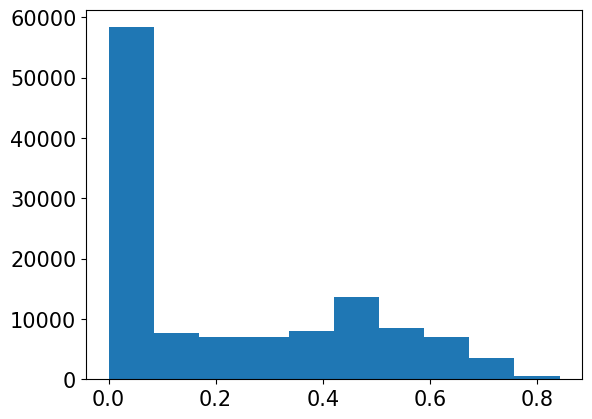

In [154]:
plt.hist(GINI_36.flatten())

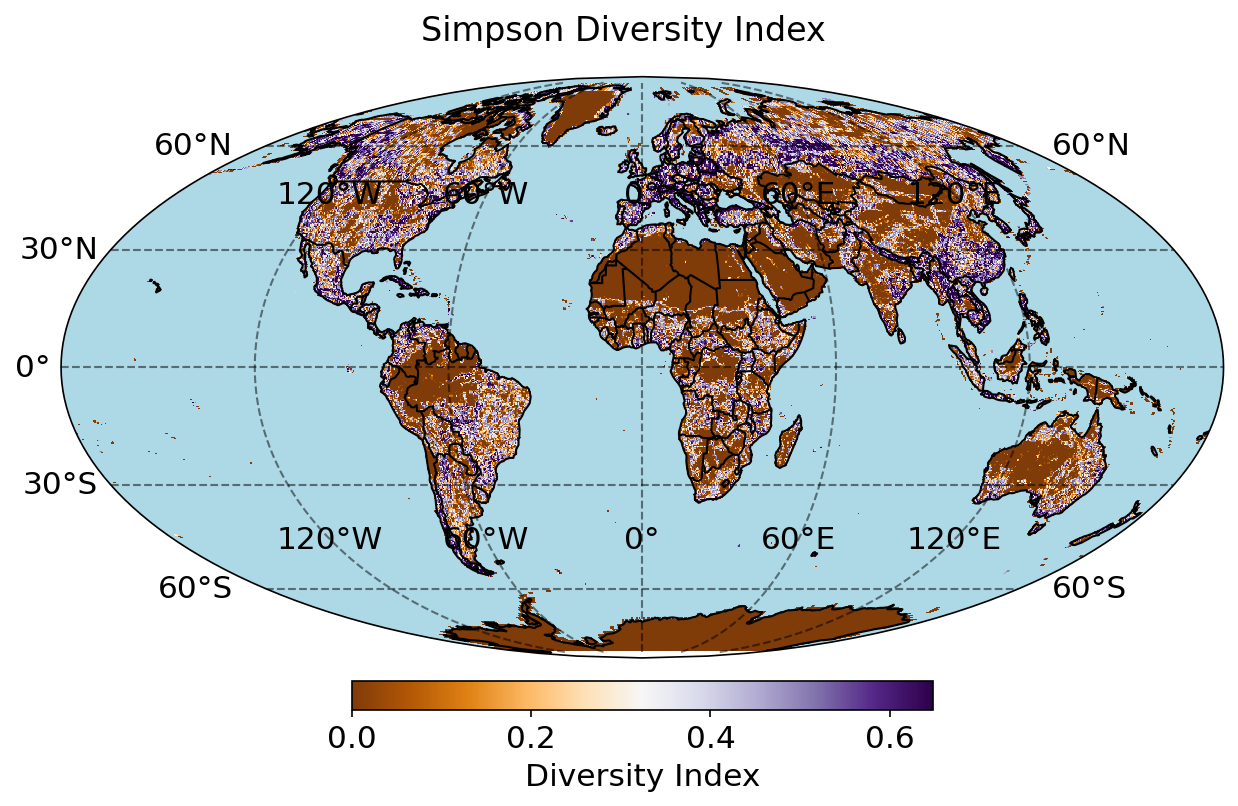

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [183]:
hPlot.plot_map(lon_36, lat_36, GINI_36, np.nanpercentile(GINI_36, 5), np.nanpercentile(GINI_36, 95), plot_title= 'Simpson Diversity Index', label_title='Diversity Index', cmap='PuOr', projection='Mollweide')

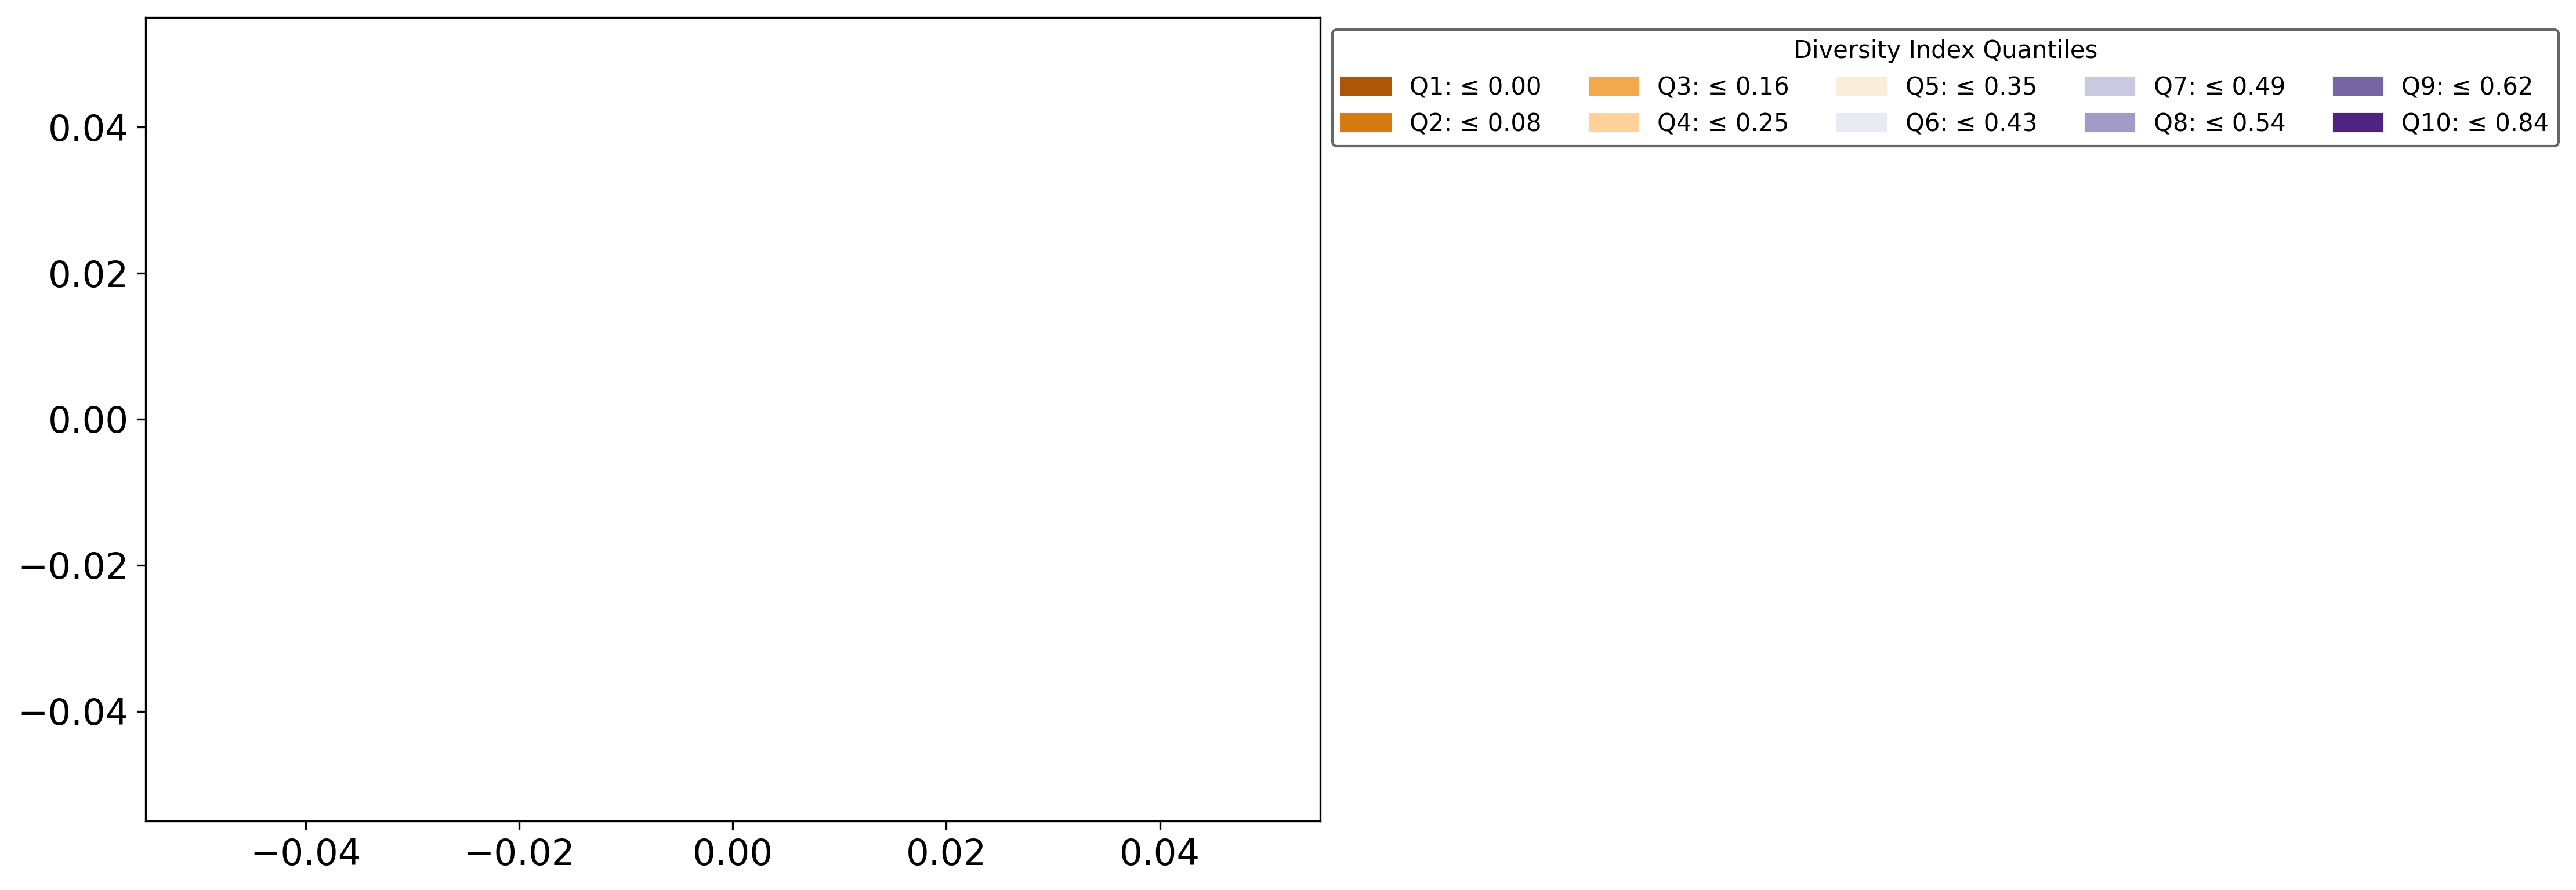

In [230]:
#quantile_values = np.nanquantile(GINI_36.flatten(), np.linspace(0.1, 1, 10))  # From 10% to 100%
zero_quantile = 0.0  # Explicitly setting the first quantile for zero values
non_zero_values = GINI_36[GINI_36 != 0].flatten()  # Exclude zeros for further quantile calculation
additional_quantiles = np.nanquantile(non_zero_values, np.linspace(0.1, 1, 9))  # From 10% to 100% of non-zero values
quantile_values = np.insert(additional_quantiles, 0, zero_quantile)  # Insert the zero quantile at the start


# Generate a Greens color palette with 10 distinct colors
palette = sns.color_palette("PuOr", n_colors=10)

# Create labels for each quantile
labels = [f'Q{i+1}: ≤ {quantile_values[i]:.2f}' for i in range(10)]

# Create a list of patches for the legend
patches = [mpatches.Patch(color=palette[i], label=labels[i]) for i in range(10)]

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Optional dummy plot for illustration
for i, color in enumerate(palette):
    ax.plot([], [], color=color)  # Creates dummy lines for visualization purposes

# Add the legend to the plot with custom settings
legend = ax.legend(handles=patches, title="Diversity Index Quantiles", loc='upper left', bbox_to_anchor=(1, 1),
                   frameon=True, framealpha=0.6, edgecolor='black', fancybox=True, shadow=False, ncol=5)

# Adjust the layout to make space for the legend
plt.subplots_adjust(right=0.8)  # Adjust this value based on your actual plot dimensions

# Display the plot
plt.show()

(array([58351.,  7640.,  6992.,  6935.,  8029., 13562.,  8530.,  7088.,
         3458.,   553.]),
 array([0.        , 0.08424745, 0.1684949 , 0.25274235, 0.3369898 ,
        0.42123724, 0.50548469, 0.58973214, 0.67397959, 0.75822704,
        0.84247449]),
 <BarContainer object of 10 artists>)

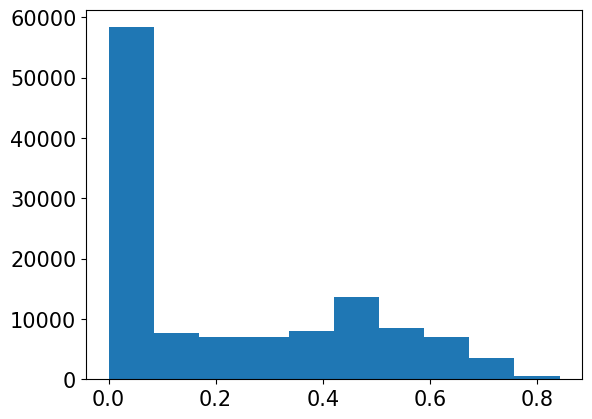

In [229]:
plt.hist(GINI_36.flatten())

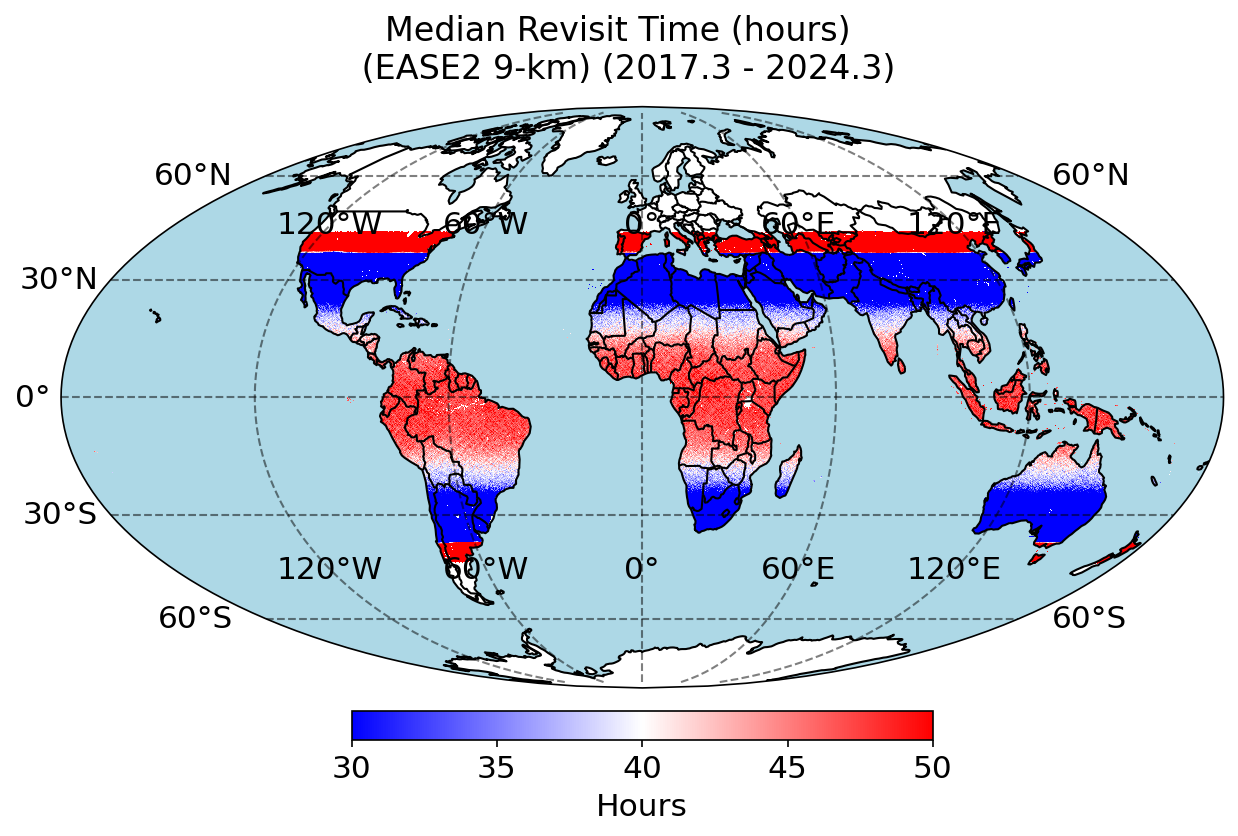

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [346]:
importlib.reload(hPlot)
#t = tr_36 / 60 / 60
#t[LULC_36 == 0] = np.nan
#hPlot.plot_map(lon_36, lat_36, t, 5, 25, plot_title= 'Median Revisit Time (hours) \n (EASE2 36-km) (2017.3 - 2024.3)', 
#               label_title='Hours', cmap='bwr', projection='Mollweide')
#
#t = tr_25 / 60 / 60
#t[LULC_25 == 0] = np.nan
#hPlot.plot_map(lon_25, lat_25, t, 5, 25, plot_title= 'Median Revisit Time (hours) \n (EASE2 25-km) (2017.3 - 2024.3)', 
#               label_title='Hours', cmap='bwr', projection='Mollweide')

t = tr_9 / 60 / 60
t[LULC_9 == 0] = np.nan
hPlot.plot_map(lon_9, lat_9, t, 30, 50, plot_title= 'Median Revisit Time (hours) \n (EASE2 9-km) (2017.3 - 2024.3)', 
               label_title='Hours', cmap='bwr', projection='Mollweide')

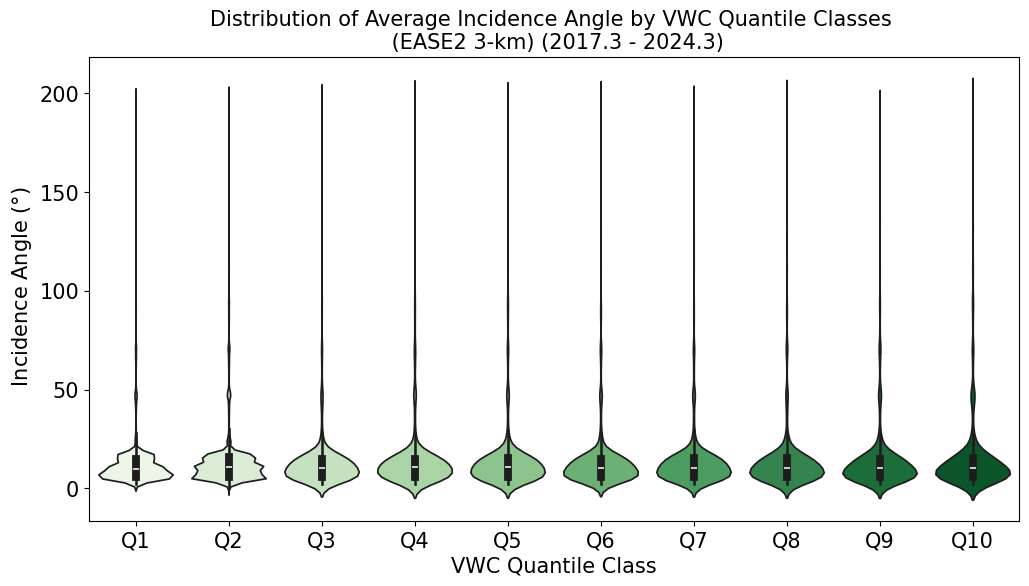

In [251]:
GINI_df = pd.DataFrame(GINI_36.flatten(), columns=['GINI'])
t = tr_36.copy()/60/60
t[t>200] = np.nan
# Define the first class for zero values
GINI_df['GINI_Class'] = np.where(GINI_df['GINI'] == 0, 1, np.nan)

# Calculate quantiles for non-zero values
non_zero_values = GINI_df[GINI_df['GINI'] != 0]['GINI']
quantiles = np.nanquantile(non_zero_values, np.linspace(0.1, 1, 9))  # Quantiles from 10% to 100% of non-zero values
quantile_edges = np.insert(quantiles, 0, non_zero_values.min())  # Insert minimum non-zero at the start

# Use pd.cut to bin non-zero values into quantiles
non_zero_classes = pd.cut(non_zero_values, bins=quantile_edges, labels=False, right=True) + 2  # Offset by 2 to account for the zero class

# Update the DataFrame with non-zero quantile classes
GINI_df.loc[GINI_df['GINI'] != 0, 'GINI_Class'] = non_zero_classes

# Fill any potential NaN values that occur due to binning edge cases
GINI_df['GINI_Class'] = GINI_df['GINI_Class'].fillna(2).astype(int)  # Treat edge cases as in the second class

# Join this back to your counts data if needed, assuming you have a similar index
tr_36_df = pd.DataFrame((t).flatten(), columns=['tr'])  # Assuming counts_36 is your counts data
combined_df = pd.concat([tr_36_df, GINI_df['GINI_Class']], axis=1)

# Dictionary to hold counts data for each VWC class
tr_GINI_classes_dic = {}

# Populate the dictionary with counts data categorized by VWC classes
for i in range(1, 11):
    tr_GINI_classes_dic[i] = combined_df['tr'][combined_df['GINI_Class'] == i].values

data_to_plot = [tr_GINI_classes_dic[i] for i in range(1, 11)]

palette = sns.color_palette("Greens", n_colors=10)

# Plotting the violin plot with the custom Greens palette
plt.figure(figsize=(12, 8))
sns.violinplot(data=data_to_plot, palette=palette, density_norm='width')
plt.title('Distribution of Average Incidence Angle by VWC Quantile Classes \n (EASE2 3-km) (2017.3 - 2024.3)')
plt.xlabel('VWC Quantile Class')
plt.ylabel(' Incidence Angle $(°)$')
#plt.ylim([0, 30])
plt.xticks(ticks=range(10), labels=[f'Q{i}' for i in range(1, 11)])
plt.gcf().subplots_adjust(bottom=0.3)
plt.show()

/var/folders/_4/qjq3yrjn047588zvn9_fc2gc0000gn/T/ipykernel_81080/172183411.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuOr')  # Get the 'PuOr' colormap


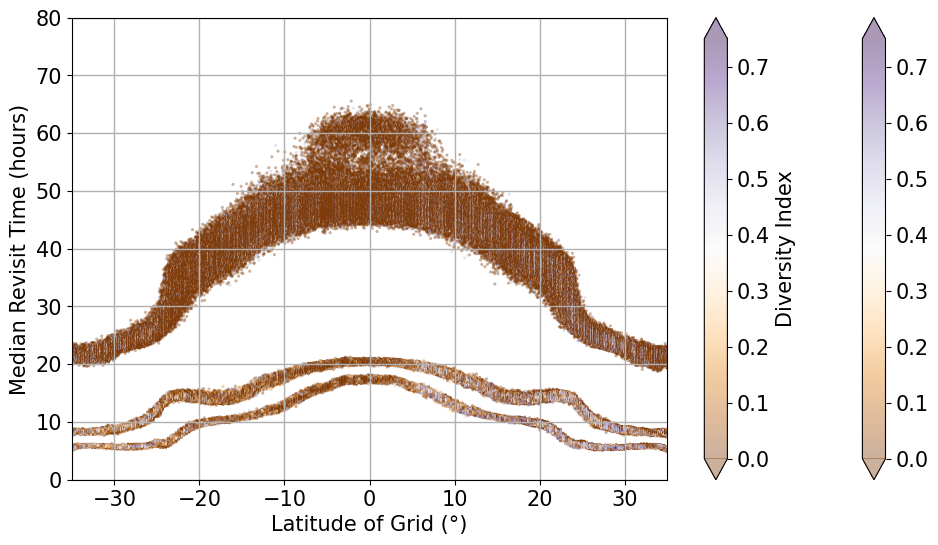

In [325]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# Sample data preparation (assuming lat_36, t, and GINI_36 are predefined)
lat = lat_36.flatten()
tr = t.flatten()  # Assuming t has been properly scaled as previously discussed
gini_values = GINI_36.flatten()

# Define a custom color map using 'PuOr'
cmap = cm.get_cmap('PuOr')  # Get the 'PuOr' colormap
colors = cmap(np.arange(cmap.N))  # Get the colors from the colormap
#colors[0, :] = [1, 0, 0, 1]  # Set the first color entry to red for zero values
custom_cmap = mcolors.ListedColormap(colors)  # Create a new colormap from the list

# Create the scatter plot with color mapping based on GINI values
plt.figure(figsize=(12, 6))
s=5  # Size of the scatter points
alpha = 0.4
scatter = plt.scatter(lat, tr, c=gini_values, cmap=custom_cmap, edgecolor='none', alpha=alpha, s=s)
scatter = plt.scatter(lat_25.flatten(), (tr_25/60/60).flatten(), c=GINI_25.flatten(), cmap=custom_cmap, edgecolor='none', alpha=alpha, s=s)
scatter = plt.scatter(lat_9.flatten(), (tr_9/60/60).flatten(), c=GINI_9.flatten(), cmap=custom_cmap, edgecolor='none', alpha=alpha, s=s)

# Set the x and y limits
plt.xlim([-35, 35])
plt.ylim([0, 80])
plt.ylabel('Median Revisit Time (hours)')
plt.xlabel('Latitude of Grid (°)')

# Adding a color bar
plt.colorbar(scatter, extend='both')
plt.grid(True)  # Show grid
plt.colorbar(scatter, extend='both').set_label('Diversity Index')

# Show the plot
plt.show()


In [ ]:
 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r',
'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays',
'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn',
'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r',
'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r',
'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds',
'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r',
'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn',
'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r',
'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r',
'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow',
'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray',
'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r',
'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r',
'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain',
'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'